# Generative Adversarial Networks and MNIST

Generative adversarial networks are actually a combination of two neural networks called the Generator and Discriminator:

![GAN Diagram](assets/GAN_diagram.jpg)

The input for the discriminator is always either a sample from the training data, or a sample created by the generator. Using this setup, the discriminator is typically a binary classifier: Its job is to classify samples as real examples (i.e. samples from the training set) or fake examples (i.e. examples created by the generator). The generator's job, then, is to produce data that realistically mimics samples from the training set. In order to force the generator to create many different samples we provide random noise as input to the generator. 

In this notebook, the real samples will be handwritten digits from the MNIST dataset, and we'll train a generator that  creates (somewhat) realistic digits.

## Preparing The Data

Like every other situation we've encoutered so far, we're going to perform some preprocessing on the image data from MNIST to maximize performance and ensure our Keras model can handle the shapes properly.

In [1]:
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dropout, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam

import numpy as np

from matplotlib import pyplot as plt

# This is a bit different than we're used to for other 
# MNIST networks we've built. Note that we don't care
# at all about the "class" — we are NOT trying to identify
# digits. We're only trying to make passable fakes.
(real_train_images, _), (real_test_images, _) = load_data()

In [2]:
# Some people suggest swapping the label value from
# what is usual, i.e. using 1 for fake and 0 for real
# in order to improve the training process. These 
# allow you to play around with that.
REAL_LABEL_VALUE = 0
FAKE_LABEL_VALUE = 1

In [3]:
# We have to do some slight processing of the MNIST input images.
# Specifically, keras expects 3 dimentional input, 
# height, width, and color channels.

# since we have black/white images we just use np.expand_dims
# to go from (28, 28) => (28, 28, 1). This should feel familiar,
# if you've used CNNs in keras at all.

# We're also going to normalize from the 0-255 domain to 0.0-1.0
def prepare_real_samples(samples):
    prepared_samples = np.expand_dims(samples, axis=-1)
    prepared_samples = prepared_samples.astype('float32')
    prepared_samples = prepared_samples / 255.0
    
    return prepared_samples


# Because the network is trained on the binary question
# "real" or "fake" this helper function selects a number 
# of samples from a set of samples that has already been
# "prepared" by the previous function. 

# We select a random sample, and provide the label
# for each of the selected samples.

# Crucially, we ASSUME that "samples" is a set of real
# examples prepared with prepare_real_samples. It is possible
# to pass fake/generated samples to this function, but that
# would be very bad for our GAN. 
def generate_real_batch(samples, n_samples):
    indices = np.random.randint(0, samples.shape[0], n_samples)
    batch_images = samples[indices]
    batch_labels = np.full((n_samples, 1), REAL_LABEL_VALUE)

    return batch_images, batch_labels


# We're going to give our discriminator a head start
# by allowing it to train, on its own, against totally
# random noise. 

# Later, we'll add a generator network and train
# the discriniator against the output of that network.
# This function generates a number of images.
def generate_random_fake_batch(n_samples, shape=(28,28,1)):
    # Random numbers 0.0-1.0 from a uniform distribution in a flat numpy Array
    batch = np.random.rand(shape[0] * shape[1] * shape[2] * n_samples)
    
    # Unflatten the list according to the provided shape
    batch = batch.reshape((n_samples, shape[0], shape[1], shape[2]))

    labels = np.full((n_samples, 1), FAKE_LABEL_VALUE)
    return batch, labels

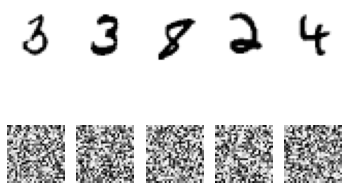

In [4]:
# Prepare the dataset
prepared_real_images = prepare_real_samples(real_train_images)

# Lets quickly visualize our "real" data vs our "fake" data.
real_x, _ = generate_real_batch(prepared_real_images, 5)
fake_x, _ = generate_random_fake_batch(5)

all_x = np.concatenate((real_x, fake_x))

for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    ax.axis('off')
    
    # imshow only works for (h, w) or (h, w, color) IF color == 3 or 4
    # we have color == 1, so we use this annoying hack to slice off
    # the last dimension. (by taking the value at the 0th position,
    # which is the only position available since we're (28,28,1))
    plt.imshow(all_x[i, :, :, 0], cmap='Greys')


## The Discriminator

The Discriminator is a CNN, a binary classifier, and in our case relatively simple. Before we move on to building the generator we're going to do a "gut check" on our discriminator architecture by checking that it can tell the difference between randomly generated noise, and digits from the MNIST dataset. 

In [5]:
# The discriminator accepts an image as input. The image is
# either a real example, or a generated one. The discriminator
# makes a binary decision about which it is, real or false.

# The default input shape is selected to match the MNIST dataset
# and could be changed to support other datasets.

# This simple network will be satisfactory for the simple MNIST dataset.
# Leaky, 2x2 striding, dropout, and batch normalization are all 
# suggested best practices for GAN at the time of this writting. 
# See "Resources for Further Exploration" for the reasoning.
def create_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    # Note the quite small learning rate.
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [6]:
# Okay, lets put all that together by training our discriminator
# on real MNIST digits for the "real" and random noise for the "fake"

INPUT_SHAPE = (28, 28, 1) # MNIST specific
BATCH_SIZE = 256          # How many of EACH real/fake to train during each round?
BATCH_N = 5               # How many rounds? 

# Get a copy of the discriminator
discriminator_network = create_discriminator(INPUT_SHAPE)

# Each of these for loop iterations is analogous to a single epoch
# but we are getting a random sample of real images, and brand new
# noise vectors each epoch. Additionally, we're not seeing EVERY real
# sample on each epoch.
for current_round in range(BATCH_N):
    real_x, real_y = generate_real_batch(prepared_real_images, BATCH_SIZE)
    fake_x, fake_y = generate_random_fake_batch(BATCH_SIZE, INPUT_SHAPE)
    
    full_x = np.concatenate((real_x, fake_x))
    full_y = np.concatenate((real_y, fake_y))
    
    print(f"Round number {current_round}")
    discriminator_network.fit(full_x, full_y, batch_size=BATCH_SIZE, epochs=1, verbose=True)


Round number 0
Train on 512 samples
512/512 [==============================] - 1s 1ms/sample - loss: 0.8160 - accuracy: 0.5371
Round number 1
Train on 512 samples
512/512 [==============================] - 0s 349us/sample - loss: 0.4909 - accuracy: 0.7559
Round number 2
Train on 512 samples
512/512 [==============================] - 0s 337us/sample - loss: 0.3549 - accuracy: 0.8613
Round number 3
Train on 512 samples
512/512 [==============================] - 0s 368us/sample - loss: 0.2374 - accuracy: 0.9336
Round number 4
Train on 512 samples
512/512 [==============================] - 0s 367us/sample - loss: 0.1712 - accuracy: 0.9746


After 5*512 = 2560 samples, our discriminator can easily distinguish between random noise and real digits. If our discriminator could not do this relatively easily / quickly, we would want to revisit our architecture until it could. 

## The Generator

In [7]:
# Generators need to recieve some random noise as the "seed" of their
# output. The amount of unique noise available to the network limits 
# the number of unique outputs the generator can create.

# Furthermore, we must transform this noise into a shape
# that our CNN can work with.

# Emperically, reseachers have had success with the strategy below
# for selecting the magnitude of this noise. Other tactics can also
# work. See the Resources for Further Exploration for more. 

# Our input shape is based on an arbitrary amount of noise.
# we'll use 100 below, but you can experiment with other values
# that also work well. 

# Our generator starts with a dense layer that should have enough nodes
# to represent several examples of a low-resolution version of our image. 
# Then, we iteratively upsample using Conv2DTranspose until
# we have images that are the right shape: (28, 28).
def create_generator(noise_dim, dense_layer_nodes):
    model = Sequential()

    model.add(Dense(dense_layer_nodes, input_dim=noise_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Reshape((7, 7, 128)))

    # Upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())

    # Upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    
    # Finally layer only has one filter and a wide convolution kernal.
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model


# We also need to generate a noise vector that matches 
# the noise shape we choose.
def generate_noise_vector(noise_dim, n_samples):
    noise_vector = np.random.randn(noise_dim * n_samples)
    noise_vector = noise_vector.reshape(n_samples, noise_dim)

    return noise_vector


# Finally, we need to be able to use the generator to 
# make a fake digit! Again, generate a batch and lables (all 0)
def generate_fake_batch(generator, noise_dim, n_samples):
    noise_vector = generate_noise_vector(noise_dim, n_samples)
    batch = generator.predict(noise_vector)
    labels = np.full((n_samples, 1), FAKE_LABEL_VALUE)

    return batch, labels

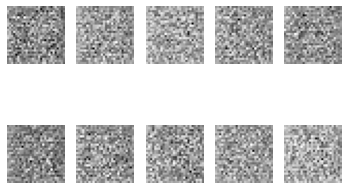

In [8]:
# Lets visualize some examples of the untrained fake
# images... they will probably still just look like 
# noise, but we can see how these functions work.

# 100 is arbitrary, but a commonly used value.
NOISE_DIM = 100

# This number should be a large enough space to represent
# "a handful of low resolution examples" of the images we're
# trying to generate. In our case, 7*7 is the "low resolution"
# (downsampled by a factor of 4, from 28 * 28 -> 7 * 7) and 128
# is "a handful".
DENSE_LAYER_SIZE = 128 * 7 * 7

# Increasing both or either the NOISE_DIM or DENSE_LAYER_SIZE will 
# increase the number of unique representations that our generator
# will ultimately generate. It will also increase the number of 
# parameters in the network of course, so it will increase training time.

generator = create_generator(NOISE_DIM, DENSE_LAYER_SIZE)

fake_images, _ = generate_fake_batch(generator, NOISE_DIM, 10)

for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    ax.axis('off')
    
    # imshow only works for (h, w) or (h, w, color) IF color == 3 or 4
    # we have color == 1, so we use this annoying hack to slice off
    # the last dimension. (by taking the value at the 0th position,
    # which is the only position available since we're (28,28,1))
    plt.imshow(fake_images[i, :, :, 0], cmap='Greys')

Wonderfully noisy. Now, how do we get this thing to produce fake digits?

## The "Generative Adversarial Network" and Training

As we mentioned, the GAN is actually a composition of both the generator and the discriminator, arranged sequentially. We need the output from the discriminator in order to train the GAN — the generator's performance is a function of its ability to trick the discrimintaor. Similarly, to train the discriminator, we need to send it samples from the generator **as well as** real samples from the training set.

Training a GAN is typically broken into three separate training processes:

1. Train the discriminator on a batch of real samples.
2. Train the discriminator on a batch of fake (generated) samples. 
3. Train the generator by freezing the discriminator and inverting the labels on generated images.

The discriminator and generator are NOT trained at the same time, instead they are trained iteratively in small batches. When the discriminator is learning, the generator's weights are not modified. When the generator is learning, the discriminators weigths are not modified. 

Lets see how this works:

In [9]:
def create_gan(generator, discriminator):
    # The output of the generator is the input to the discriminator.
    # The output of the discriminator matches our lables (0, 1) for (fake, real)
    model = Sequential()
    model.add(generator)

    # When the GAN trains, it only trains the generator.
    # the discriminator has to be trained separately. 
    # This honestly seems like the wrong way to do this...
    # But apparently it's totally legit: https://github.com/keras-team/keras/issues/8585
    discriminator.trainable = False
    model.add(discriminator)
    
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model


# A lot of work has gone into figuring out strategies
# for training GANs, and some of the best practices include:

# Freezing the discriminator while we train the generator, this
# creates a stable target for the generator to work against. 

# Periodically updating the discriminator BY ITSELF with batches
# of fake images from the generator and real images from the dataset. 

# Inverting the label of "fake" images during generator training. 
#   In order to fool the discriminator, we invert the labels.
#   The idea is that when the discrimiator is doing a GOOD job 
#   (i.e. low loss / error) we need to tell the generator that its
#   doing a BAD job. A very quick way to achieve this is to flip
#   labels when training the generator. 
def train_gan(gan, generator, discriminator, noise_dim, batches, batch_size, verbose=True):
    print("Training... \nDiscriminator Real Acc, Discriminator Fake Acc, Generator Acc")
    for i in range(batches):
        real_batch_images, real_batch_labels = generate_real_batch(prepared_real_images, batch_size // 2)
        fake_batch_images, fake_batch_labels = generate_fake_batch(generator, noise_dim, batch_size // 2)


        # Training a batch of real, then a batch of fake, rather than a shuffled mix
        # could impact training, but it gives us more granular information about the
        # discriminator's performance. 
        _, discriminator_real_acc = discriminator.train_on_batch(real_batch_images, real_batch_labels)
        _, discriminator_fake_acc = discriminator.train_on_batch(fake_batch_images, fake_batch_labels)
        
        
        # Make some noise for the full model to train on
        gan_input_vector = generate_noise_vector(noise_dim, batch_size)

        # In order to fool the discriminator, we invert the labels.
        # The idea is that when the discrimiator is doing a GOOD job 
        # (i.e. low loss / error) we need to tell the generator that its
        # doing a BAD job. A very quick way to achieve this is to flip
        # labels when training the generator. 
        gan_labels = np.full((batch_size, 1), REAL_LABEL_VALUE)
        _, gan_acc = gan.train_on_batch(gan_input_vector, gan_labels)
        
        if verbose: print(f"{i} / {batches}: {discriminator_real_acc}, {discriminator_fake_acc}, {gan_acc}")

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.4375, 0.90625, 0.34375
1 / 100: 0.546875, 0.96875, 0.3828125
2 / 100: 0.7421875, 1.0, 0.46484375
3 / 100: 0.796875, 0.984375, 0.5390625
4 / 100: 0.796875, 1.0, 0.5859375
5 / 100: 0.921875, 1.0, 0.671875
6 / 100: 0.9140625, 1.0, 0.71484375
7 / 100: 0.9765625, 1.0, 0.859375
8 / 100: 0.96875, 1.0, 0.82421875
9 / 100: 0.9921875, 1.0, 0.90234375
10 / 100: 0.9921875, 1.0, 0.88671875
11 / 100: 1.0, 1.0, 0.96484375
12 / 100: 1.0, 1.0, 0.95703125
13 / 100: 0.9921875, 1.0, 0.9765625
14 / 100: 0.9921875, 1.0, 0.96875
15 / 100: 1.0, 1.0, 0.9921875
16 / 100: 1.0, 1.0, 0.9921875
17 / 100: 0.9921875, 1.0, 1.0
18 / 100: 1.0, 1.0, 1.0
19 / 100: 1.0, 1.0, 1.0
20 / 100: 1.0, 1.0, 1.0
21 / 100: 1.0, 1.0, 1.0
22 / 100: 1.0, 1.0, 1.0
23 / 100: 1.0, 1.0, 1.0
24 / 100: 1.0, 1.0, 1.0
25 / 100: 0.9921875, 1.0, 1.0
26 / 100: 1.0, 1.0, 1.0
27 / 100: 1.0, 1.0, 0.99609375
28 / 100: 1.0, 1.0, 1.0
29 / 100: 1.0, 1.0, 1.0
30 / 100: 1

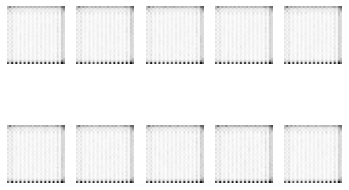

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 1.0
1 / 100: 1.0, 1.0, 1.0
2 / 100: 1.0, 1.0, 1.0
3 / 100: 1.0, 1.0, 1.0
4 / 100: 1.0, 1.0, 1.0
5 / 100: 1.0, 1.0, 1.0
6 / 100: 1.0, 1.0, 1.0
7 / 100: 1.0, 1.0, 1.0
8 / 100: 1.0, 1.0, 1.0
9 / 100: 1.0, 1.0, 1.0
10 / 100: 1.0, 1.0, 1.0
11 / 100: 1.0, 1.0, 1.0
12 / 100: 1.0, 1.0, 1.0
13 / 100: 1.0, 1.0, 1.0
14 / 100: 1.0, 1.0, 1.0
15 / 100: 1.0, 1.0, 1.0
16 / 100: 1.0, 1.0, 1.0
17 / 100: 1.0, 1.0, 1.0
18 / 100: 1.0, 1.0, 1.0
19 / 100: 1.0, 1.0, 1.0
20 / 100: 1.0, 1.0, 1.0
21 / 100: 1.0, 1.0, 1.0
22 / 100: 1.0, 1.0, 1.0
23 / 100: 1.0, 1.0, 1.0
24 / 100: 1.0, 1.0, 1.0
25 / 100: 1.0, 1.0, 1.0
26 / 100: 1.0, 1.0, 1.0
27 / 100: 1.0, 1.0, 1.0
28 / 100: 1.0, 1.0, 1.0
29 / 100: 1.0, 1.0, 1.0
30 / 100: 1.0, 1.0, 1.0
31 / 100: 1.0, 1.0, 1.0
32 / 100: 1.0, 1.0, 1.0
33 / 100: 1.0, 1.0, 1.0
34 / 100: 1.0, 1.0, 1.0
35 / 100: 1.0, 1.0, 1.0
36 / 100: 1.0, 1.0, 1.0
37 / 100: 1.0, 1.0, 1.0
38 / 100: 1.0, 1.0, 1.0

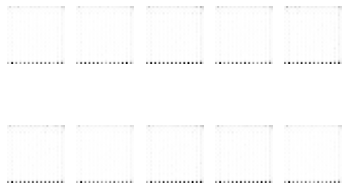

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 1.0
1 / 100: 1.0, 1.0, 1.0
2 / 100: 1.0, 1.0, 1.0
3 / 100: 1.0, 1.0, 1.0
4 / 100: 1.0, 1.0, 1.0
5 / 100: 1.0, 1.0, 1.0
6 / 100: 1.0, 1.0, 1.0
7 / 100: 1.0, 1.0, 1.0
8 / 100: 1.0, 1.0, 1.0
9 / 100: 1.0, 1.0, 1.0
10 / 100: 1.0, 1.0, 1.0
11 / 100: 1.0, 1.0, 1.0
12 / 100: 1.0, 1.0, 1.0
13 / 100: 1.0, 1.0, 1.0
14 / 100: 1.0, 1.0, 1.0
15 / 100: 1.0, 1.0, 1.0
16 / 100: 1.0, 1.0, 1.0
17 / 100: 1.0, 1.0, 1.0
18 / 100: 1.0, 1.0, 1.0
19 / 100: 1.0, 1.0, 1.0
20 / 100: 1.0, 1.0, 1.0
21 / 100: 1.0, 1.0, 1.0
22 / 100: 1.0, 1.0, 1.0
23 / 100: 1.0, 1.0, 1.0
24 / 100: 1.0, 1.0, 1.0
25 / 100: 1.0, 1.0, 1.0
26 / 100: 1.0, 1.0, 1.0
27 / 100: 1.0, 1.0, 1.0
28 / 100: 1.0, 1.0, 1.0
29 / 100: 1.0, 1.0, 1.0
30 / 100: 1.0, 1.0, 1.0
31 / 100: 1.0, 1.0, 1.0
32 / 100: 1.0, 1.0, 1.0
33 / 100: 1.0, 1.0, 1.0
34 / 100: 1.0, 1.0, 1.0
35 / 100: 1.0, 1.0, 1.0
36 / 100: 1.0, 1.0, 1.0
37 / 100: 1.0, 1.0, 1.0
38 / 100: 1.0, 1.0, 1.0

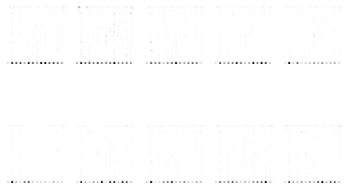

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 1.0
1 / 100: 1.0, 1.0, 1.0
2 / 100: 1.0, 1.0, 1.0
3 / 100: 1.0, 1.0, 1.0
4 / 100: 1.0, 1.0, 1.0
5 / 100: 1.0, 1.0, 1.0
6 / 100: 1.0, 1.0, 1.0
7 / 100: 1.0, 1.0, 1.0
8 / 100: 1.0, 1.0, 1.0
9 / 100: 1.0, 1.0, 1.0
10 / 100: 1.0, 1.0, 1.0
11 / 100: 1.0, 1.0, 1.0
12 / 100: 1.0, 1.0, 1.0
13 / 100: 1.0, 1.0, 1.0
14 / 100: 1.0, 1.0, 1.0
15 / 100: 1.0, 1.0, 1.0
16 / 100: 1.0, 1.0, 1.0
17 / 100: 1.0, 1.0, 1.0
18 / 100: 1.0, 1.0, 1.0
19 / 100: 1.0, 1.0, 1.0
20 / 100: 1.0, 1.0, 1.0
21 / 100: 1.0, 1.0, 1.0
22 / 100: 1.0, 1.0, 1.0
23 / 100: 1.0, 1.0, 1.0
24 / 100: 1.0, 1.0, 1.0
25 / 100: 1.0, 1.0, 1.0
26 / 100: 1.0, 1.0, 1.0
27 / 100: 1.0, 1.0, 1.0
28 / 100: 1.0, 1.0, 1.0
29 / 100: 1.0, 1.0, 1.0
30 / 100: 1.0, 1.0, 1.0
31 / 100: 1.0, 1.0, 1.0
32 / 100: 1.0, 1.0, 1.0
33 / 100: 1.0, 1.0, 1.0
34 / 100: 1.0, 1.0, 1.0
35 / 100: 1.0, 1.0, 1.0
36 / 100: 1.0, 1.0, 1.0
37 / 100: 1.0, 1.0, 1.0
38 / 100: 1.0, 1.0, 1.0

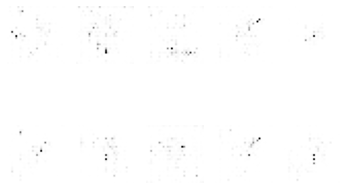

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 0.9765625, 1.0
1 / 100: 1.0, 0.9609375, 0.98828125
2 / 100: 1.0, 1.0, 0.9921875
3 / 100: 1.0, 0.9921875, 1.0
4 / 100: 1.0, 1.0, 0.99609375
5 / 100: 0.9921875, 0.9921875, 1.0
6 / 100: 1.0, 0.984375, 1.0
7 / 100: 1.0, 1.0, 1.0
8 / 100: 1.0, 1.0, 0.99609375
9 / 100: 1.0, 1.0, 1.0
10 / 100: 1.0, 1.0, 1.0
11 / 100: 1.0, 0.9921875, 1.0
12 / 100: 1.0, 1.0, 1.0
13 / 100: 1.0, 1.0, 1.0
14 / 100: 1.0, 1.0, 1.0
15 / 100: 1.0, 0.9921875, 1.0
16 / 100: 1.0, 1.0, 1.0
17 / 100: 1.0, 0.9921875, 0.9921875
18 / 100: 1.0, 1.0, 1.0
19 / 100: 1.0, 1.0, 1.0
20 / 100: 1.0, 1.0, 1.0
21 / 100: 1.0, 1.0, 1.0
22 / 100: 1.0, 0.9921875, 1.0
23 / 100: 1.0, 0.9921875, 1.0
24 / 100: 1.0, 1.0, 1.0
25 / 100: 1.0, 1.0, 1.0
26 / 100: 1.0, 0.9921875, 1.0
27 / 100: 1.0, 1.0, 1.0
28 / 100: 1.0, 1.0, 1.0
29 / 100: 1.0, 0.9921875, 1.0
30 / 100: 1.0, 1.0, 1.0
31 / 100: 1.0, 1.0, 1.0
32 / 100: 1.0, 1.0, 1.0
33 / 100: 1.0, 1.0, 1.0
34 / 100:

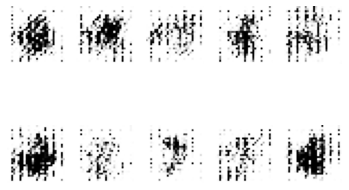

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.984375, 0.9609375, 0.98828125
1 / 100: 1.0, 0.9921875, 0.98828125
2 / 100: 0.9921875, 0.9921875, 0.9921875
3 / 100: 1.0, 0.984375, 0.98828125
4 / 100: 1.0, 1.0, 0.9765625
5 / 100: 1.0, 0.9921875, 0.96875
6 / 100: 1.0, 0.9765625, 0.921875
7 / 100: 1.0, 0.9921875, 0.92578125
8 / 100: 1.0, 0.953125, 0.8671875
9 / 100: 0.9921875, 0.984375, 0.80078125
10 / 100: 1.0, 0.9921875, 0.7890625
11 / 100: 1.0, 0.9453125, 0.578125
12 / 100: 0.9921875, 0.9921875, 0.61328125
13 / 100: 0.9921875, 0.9765625, 0.390625
14 / 100: 1.0, 1.0, 0.36328125
15 / 100: 0.984375, 0.9765625, 0.28515625
16 / 100: 0.9765625, 0.9765625, 0.12109375
17 / 100: 1.0, 0.9765625, 0.04296875
18 / 100: 0.9609375, 0.9921875, 0.015625
19 / 100: 0.9921875, 0.9921875, 0.0
20 / 100: 0.9921875, 0.9921875, 0.0
21 / 100: 0.984375, 0.9921875, 0.0
22 / 100: 0.9921875, 0.9453125, 0.0
23 / 100: 0.9296875, 1.0, 0.0
24 / 100: 1.0, 0.9765625, 0.0
25 / 100: 0.9

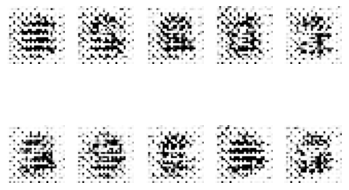

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 0.43359375
1 / 100: 0.9921875, 1.0, 0.44140625
2 / 100: 1.0, 1.0, 0.44140625
3 / 100: 1.0, 1.0, 0.453125
4 / 100: 0.9921875, 1.0, 0.44921875
5 / 100: 1.0, 1.0, 0.43359375
6 / 100: 1.0, 1.0, 0.45703125
7 / 100: 1.0, 1.0, 0.39453125
8 / 100: 1.0, 1.0, 0.44921875
9 / 100: 1.0, 1.0, 0.390625
10 / 100: 1.0, 0.9921875, 0.31640625
11 / 100: 1.0, 1.0, 0.26953125
12 / 100: 1.0, 1.0, 0.26953125
13 / 100: 1.0, 1.0, 0.19140625
14 / 100: 1.0, 1.0, 0.2109375
15 / 100: 0.9921875, 1.0, 0.1953125
16 / 100: 1.0, 1.0, 0.1484375
17 / 100: 1.0, 1.0, 0.0703125
18 / 100: 1.0, 1.0, 0.0859375
19 / 100: 1.0, 0.9921875, 0.0625
20 / 100: 0.984375, 0.9921875, 0.0234375
21 / 100: 0.9921875, 1.0, 0.03515625
22 / 100: 1.0, 1.0, 0.03125
23 / 100: 0.9921875, 0.984375, 0.01171875
24 / 100: 0.9921875, 1.0, 0.01953125
25 / 100: 1.0, 0.9453125, 0.0078125
26 / 100: 0.9140625, 1.0, 0.01171875
27 / 100: 1.0, 0.765625, 0.0
28 / 100: 0

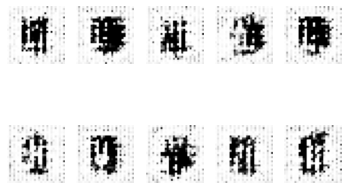

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 0.890625, 0.00390625
1 / 100: 1.0, 1.0, 0.0
2 / 100: 0.9453125, 1.0, 0.0390625
3 / 100: 1.0, 0.859375, 0.0
4 / 100: 0.9609375, 1.0, 0.01171875
5 / 100: 0.9609375, 1.0, 0.015625
6 / 100: 1.0, 0.9765625, 0.0
7 / 100: 1.0, 1.0, 0.015625
8 / 100: 0.9921875, 1.0, 0.08203125
9 / 100: 1.0, 0.9921875, 0.09765625
10 / 100: 1.0, 1.0, 0.11328125
11 / 100: 1.0, 1.0, 0.1484375
12 / 100: 1.0, 1.0, 0.10546875
13 / 100: 1.0, 0.9921875, 0.16015625
14 / 100: 1.0, 1.0, 0.12890625
15 / 100: 1.0, 1.0, 0.12109375
16 / 100: 1.0, 1.0, 0.1171875
17 / 100: 0.9921875, 1.0, 0.13671875
18 / 100: 1.0, 1.0, 0.10546875
19 / 100: 1.0, 1.0, 0.11328125
20 / 100: 1.0, 1.0, 0.18359375
21 / 100: 1.0, 1.0, 0.15625
22 / 100: 1.0, 1.0, 0.11328125
23 / 100: 1.0, 1.0, 0.2109375
24 / 100: 1.0, 1.0, 0.20703125
25 / 100: 1.0, 1.0, 0.203125
26 / 100: 1.0, 1.0, 0.203125
27 / 100: 1.0, 1.0, 0.2265625
28 / 100: 1.0, 1.0, 0.21875
29 / 100: 1.0, 1.0

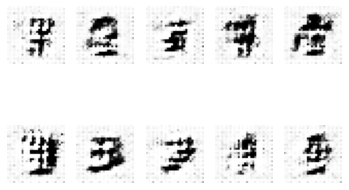

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.9921875, 1.0, 0.19921875
1 / 100: 1.0, 1.0, 0.12109375
2 / 100: 1.0, 1.0, 0.09765625
3 / 100: 0.9921875, 1.0, 0.1171875
4 / 100: 0.9921875, 0.984375, 0.07421875
5 / 100: 0.9921875, 1.0, 0.13671875
6 / 100: 1.0, 0.9921875, 0.1953125
7 / 100: 1.0, 1.0, 0.1015625
8 / 100: 1.0, 0.9921875, 0.12109375
9 / 100: 0.9921875, 1.0, 0.13671875
10 / 100: 0.9921875, 0.9921875, 0.06640625
11 / 100: 1.0, 1.0, 0.046875
12 / 100: 1.0, 1.0, 0.05078125
13 / 100: 1.0, 1.0, 0.0390625
14 / 100: 0.9921875, 1.0, 0.05859375
15 / 100: 0.9921875, 0.984375, 0.05859375
16 / 100: 0.9765625, 0.9765625, 0.06640625
17 / 100: 0.9921875, 1.0, 0.05078125
18 / 100: 0.984375, 0.9921875, 0.0390625
19 / 100: 0.984375, 1.0, 0.11328125
20 / 100: 0.984375, 1.0, 0.140625
21 / 100: 0.984375, 0.9765625, 0.04296875
22 / 100: 0.984375, 1.0, 0.03125
23 / 100: 0.9921875, 1.0, 0.125
24 / 100: 0.9921875, 0.96875, 0.04296875
25 / 100: 0.984375, 1.0, 0.042

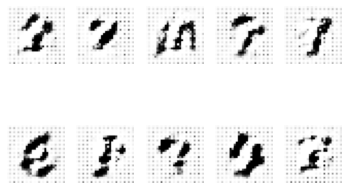

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.984375, 1.0, 0.0078125
1 / 100: 0.984375, 0.9921875, 0.01171875
2 / 100: 0.9921875, 0.984375, 0.0859375
3 / 100: 0.9921875, 0.9921875, 0.0078125
4 / 100: 0.9921875, 1.0, 0.01953125
5 / 100: 0.9921875, 0.9765625, 0.1015625
6 / 100: 0.984375, 0.9921875, 0.015625
7 / 100: 1.0, 1.0, 0.0390625
8 / 100: 0.9765625, 0.9609375, 0.15234375
9 / 100: 0.96875, 1.0, 0.06640625
10 / 100: 0.9921875, 0.9921875, 0.0625
11 / 100: 0.984375, 0.953125, 0.078125
12 / 100: 0.9609375, 1.0, 0.09765625
13 / 100: 0.9921875, 0.9921875, 0.1328125
14 / 100: 0.9765625, 0.953125, 0.1171875
15 / 100: 0.96875, 0.984375, 0.0859375
16 / 100: 0.9609375, 0.9921875, 0.0546875
17 / 100: 0.9921875, 0.9609375, 0.0390625
18 / 100: 0.9453125, 1.0, 0.09765625
19 / 100: 1.0, 0.96875, 0.1015625
20 / 100: 0.9765625, 0.9453125, 0.046875
21 / 100: 0.984375, 0.9765625, 0.08203125
22 / 100: 0.8984375, 0.9375, 0.23046875
23 / 100: 0.9765625, 0.9296875, 0

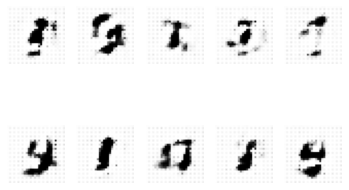

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.953125, 0.9375, 0.65625
1 / 100: 0.9140625, 0.9375, 0.703125
2 / 100: 0.9609375, 0.9765625, 0.76171875
3 / 100: 0.9609375, 0.9765625, 0.84765625
4 / 100: 0.9296875, 0.96875, 0.82421875
5 / 100: 0.96875, 0.9921875, 0.84765625
6 / 100: 0.96875, 0.9453125, 0.82421875
7 / 100: 0.9765625, 0.90625, 0.83203125
8 / 100: 0.8984375, 0.984375, 0.86328125
9 / 100: 0.984375, 0.90625, 0.828125
10 / 100: 0.9921875, 0.9765625, 0.82421875
11 / 100: 0.9296875, 0.9765625, 0.8359375
12 / 100: 0.9609375, 0.9921875, 0.73828125
13 / 100: 0.90625, 0.890625, 0.66796875
14 / 100: 0.953125, 0.859375, 0.46875
15 / 100: 0.6640625, 0.7890625, 0.390625
16 / 100: 0.8984375, 1.0, 0.5703125
17 / 100: 0.9765625, 0.5703125, 0.28515625
18 / 100: 0.7265625, 0.984375, 0.34375
19 / 100: 0.984375, 0.5546875, 0.21875
20 / 100: 0.484375, 0.96875, 0.3984375
21 / 100: 0.984375, 0.6640625, 0.2421875
22 / 100: 0.84375, 0.7734375, 0.2421875
23 / 10

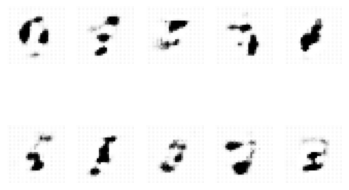

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.9765625, 0.90625, 1.0
1 / 100: 0.9140625, 0.921875, 1.0
2 / 100: 0.875, 0.9140625, 0.99609375
3 / 100: 0.9453125, 0.9609375, 0.99609375
4 / 100: 0.90625, 1.0, 1.0
5 / 100: 0.9609375, 0.8828125, 0.9921875
6 / 100: 0.9453125, 0.953125, 0.99609375
7 / 100: 0.8984375, 0.953125, 0.98828125
8 / 100: 0.96875, 0.9140625, 0.984375
9 / 100: 0.9609375, 0.9453125, 0.96875
10 / 100: 0.953125, 0.921875, 0.94921875
11 / 100: 0.859375, 0.890625, 0.98046875
12 / 100: 0.9609375, 0.9765625, 0.953125
13 / 100: 0.921875, 0.9296875, 0.953125
14 / 100: 0.953125, 0.96875, 0.9140625
15 / 100: 0.90625, 0.9453125, 0.8984375
16 / 100: 0.9296875, 0.953125, 0.83203125
17 / 100: 0.9453125, 0.96875, 0.8828125
18 / 100: 0.9375, 0.9375, 0.87890625
19 / 100: 0.9140625, 0.921875, 0.92578125
20 / 100: 1.0, 0.9765625, 0.921875
21 / 100: 0.8984375, 0.921875, 0.93359375
22 / 100: 0.921875, 0.96875, 0.9453125
23 / 100: 0.9140625, 0.9609375, 

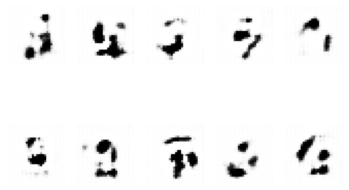

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.9296875, 0.8203125, 0.2109375
1 / 100: 0.890625, 0.859375, 0.17578125
2 / 100: 0.90625, 0.9140625, 0.1875
3 / 100: 0.8125, 0.9140625, 0.30859375
4 / 100: 0.9375, 0.8984375, 0.3671875
5 / 100: 0.9140625, 0.859375, 0.42578125
6 / 100: 0.953125, 0.90625, 0.3984375
7 / 100: 0.875, 0.984375, 0.375
8 / 100: 0.9609375, 0.90625, 0.3046875
9 / 100: 0.828125, 0.890625, 0.28125
10 / 100: 0.96875, 0.90625, 0.3203125
11 / 100: 0.859375, 0.9609375, 0.2578125
12 / 100: 0.96875, 0.8515625, 0.26171875
13 / 100: 0.8671875, 0.9375, 0.2421875
14 / 100: 0.8515625, 0.9453125, 0.28125
15 / 100: 0.9140625, 0.96875, 0.265625
16 / 100: 0.921875, 0.9140625, 0.30859375
17 / 100: 0.921875, 0.84375, 0.2578125
18 / 100: 0.921875, 0.9375, 0.25390625
19 / 100: 0.8515625, 0.9453125, 0.2109375
20 / 100: 0.953125, 0.9375, 0.2734375
21 / 100: 0.9453125, 0.859375, 0.14453125
22 / 100: 0.8359375, 0.8046875, 0.140625
23 / 100: 0.8984375, 0.

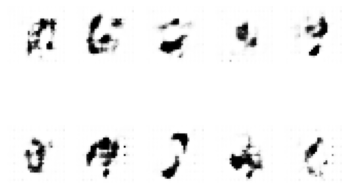

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.9765625, 0.9921875, 0.4453125
1 / 100: 0.9765625, 1.0, 0.44140625
2 / 100: 0.984375, 0.984375, 0.57421875
3 / 100: 0.984375, 0.9609375, 0.546875
4 / 100: 0.96875, 0.9765625, 0.53515625
5 / 100: 0.96875, 1.0, 0.5859375
6 / 100: 0.96875, 0.984375, 0.6484375
7 / 100: 0.984375, 0.9453125, 0.65234375
8 / 100: 0.953125, 0.9921875, 0.61328125
9 / 100: 0.984375, 1.0, 0.6171875
10 / 100: 0.953125, 0.96875, 0.6171875
11 / 100: 0.9921875, 1.0, 0.61328125
12 / 100: 0.9921875, 0.9921875, 0.56640625
13 / 100: 0.9921875, 0.96875, 0.56640625
14 / 100: 0.96875, 1.0, 0.66796875
15 / 100: 0.984375, 0.953125, 0.67578125
16 / 100: 0.9609375, 0.9921875, 0.734375
17 / 100: 0.9609375, 0.9921875, 0.703125
18 / 100: 0.984375, 1.0, 0.65625
19 / 100: 0.984375, 0.984375, 0.51171875
20 / 100: 0.984375, 0.984375, 0.57421875
21 / 100: 0.9453125, 1.0, 0.53125
22 / 100: 0.9765625, 0.9765625, 0.46875
23 / 100: 0.96875, 0.953125, 0.4101

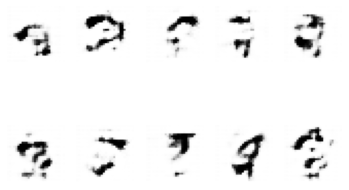

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.546875, 0.9921875, 0.046875
1 / 100: 0.984375, 0.671875, 0.046875
2 / 100: 0.8515625, 1.0, 0.0234375
3 / 100: 0.890625, 0.828125, 0.0078125
4 / 100: 0.9765625, 1.0, 0.015625
5 / 100: 0.921875, 0.703125, 0.0
6 / 100: 0.65625, 0.984375, 0.03125
7 / 100: 1.0, 0.6328125, 0.0
8 / 100: 0.75, 1.0, 0.0078125
9 / 100: 0.890625, 0.6171875, 0.00390625
10 / 100: 0.984375, 1.0, 0.0
11 / 100: 0.6484375, 0.3125, 0.0
12 / 100: 0.46875, 0.953125, 0.015625
13 / 100: 0.96875, 0.6796875, 0.0
14 / 100: 0.765625, 0.9140625, 0.0
15 / 100: 0.84375, 1.0, 0.00390625
16 / 100: 0.921875, 0.40625, 0.0
17 / 100: 0.6953125, 1.0, 0.0
18 / 100: 0.65625, 0.984375, 0.00390625
19 / 100: 1.0, 0.609375, 0.0
20 / 100: 0.984375, 1.0, 0.0
21 / 100: 0.8359375, 1.0, 0.0
22 / 100: 0.96875, 0.9296875, 0.0
23 / 100: 0.96875, 0.9296875, 0.0
24 / 100: 0.96875, 0.96875, 0.0
25 / 100: 0.890625, 0.984375, 0.0
26 / 100: 1.0, 0.90625, 0.0
27 / 100: 0.95

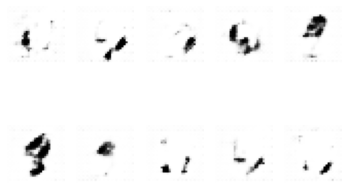

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 0.82421875
1 / 100: 1.0, 1.0, 0.8125
2 / 100: 1.0, 0.9921875, 0.8359375
3 / 100: 1.0, 1.0, 0.8125
4 / 100: 1.0, 1.0, 0.84375
5 / 100: 1.0, 1.0, 0.8046875
6 / 100: 1.0, 1.0, 0.8125
7 / 100: 1.0, 1.0, 0.7421875
8 / 100: 1.0, 1.0, 0.7734375
9 / 100: 0.9765625, 1.0, 0.77734375
10 / 100: 1.0, 0.9921875, 0.7421875
11 / 100: 1.0, 1.0, 0.7890625
12 / 100: 1.0, 0.9921875, 0.7734375
13 / 100: 1.0, 1.0, 0.73828125
14 / 100: 1.0, 1.0, 0.67578125
15 / 100: 0.984375, 1.0, 0.72265625
16 / 100: 1.0, 1.0, 0.78125
17 / 100: 0.984375, 1.0, 0.83203125
18 / 100: 1.0, 0.9921875, 0.79296875
19 / 100: 1.0, 1.0, 0.69921875
20 / 100: 0.9921875, 1.0, 0.78515625
21 / 100: 0.9921875, 0.9921875, 0.7734375
22 / 100: 0.9921875, 0.9921875, 0.76171875
23 / 100: 1.0, 0.9921875, 0.8125
24 / 100: 0.9921875, 1.0, 0.7265625
25 / 100: 1.0, 1.0, 0.69921875
26 / 100: 1.0, 0.9921875, 0.6875
27 / 100: 1.0, 1.0, 0.6640625
28 / 100: 0.992

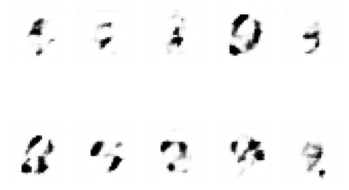

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 0.8515625
1 / 100: 1.0, 1.0, 0.85546875
2 / 100: 1.0, 1.0, 0.83203125
3 / 100: 1.0, 1.0, 0.87109375
4 / 100: 1.0, 1.0, 0.89453125
5 / 100: 0.9765625, 1.0, 0.9140625
6 / 100: 0.9921875, 1.0, 0.92578125
7 / 100: 1.0, 1.0, 0.92578125
8 / 100: 1.0, 1.0, 0.91015625
9 / 100: 0.9921875, 1.0, 0.90625
10 / 100: 1.0, 1.0, 0.875
11 / 100: 0.9921875, 0.96875, 0.9140625
12 / 100: 0.9921875, 1.0, 0.9296875
13 / 100: 1.0, 1.0, 0.94921875
14 / 100: 0.984375, 1.0, 0.93359375
15 / 100: 1.0, 1.0, 0.96484375
16 / 100: 1.0, 1.0, 0.93359375
17 / 100: 0.984375, 1.0, 0.9609375
18 / 100: 1.0, 1.0, 0.95703125
19 / 100: 1.0, 0.9921875, 0.94921875
20 / 100: 1.0, 1.0, 0.98046875
21 / 100: 1.0, 1.0, 0.96484375
22 / 100: 1.0, 0.9921875, 0.94921875
23 / 100: 1.0, 1.0, 0.94921875
24 / 100: 0.9921875, 1.0, 0.953125
25 / 100: 1.0, 1.0, 0.9453125
26 / 100: 1.0, 1.0, 0.95703125
27 / 100: 0.9921875, 1.0, 0.98046875
28 / 100: 1.0, 

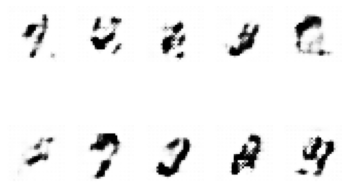

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 0.22265625
1 / 100: 1.0, 1.0, 0.3203125
2 / 100: 0.9921875, 1.0, 0.30078125
3 / 100: 0.9921875, 1.0, 0.2109375
4 / 100: 1.0, 1.0, 0.24609375
5 / 100: 1.0, 0.9921875, 0.23828125
6 / 100: 0.9921875, 0.984375, 0.24609375
7 / 100: 0.9765625, 1.0, 0.2265625
8 / 100: 1.0, 0.953125, 0.15234375
9 / 100: 0.9921875, 1.0, 0.09765625
10 / 100: 0.9921875, 0.9609375, 0.0859375
11 / 100: 1.0, 1.0, 0.0859375
12 / 100: 0.9765625, 1.0, 0.12109375
13 / 100: 0.9921875, 1.0, 0.08984375
14 / 100: 1.0, 0.9921875, 0.14453125
15 / 100: 0.984375, 1.0, 0.12890625
16 / 100: 1.0, 1.0, 0.140625
17 / 100: 1.0, 1.0, 0.12109375
18 / 100: 1.0, 0.9609375, 0.125
19 / 100: 1.0, 1.0, 0.11328125
20 / 100: 0.984375, 0.984375, 0.1484375
21 / 100: 1.0, 1.0, 0.1640625
22 / 100: 1.0, 0.984375, 0.15625
23 / 100: 0.984375, 0.9765625, 0.203125
24 / 100: 0.9921875, 1.0, 0.18359375
25 / 100: 1.0, 1.0, 0.18359375
26 / 100: 1.0, 1.0, 0.2070312

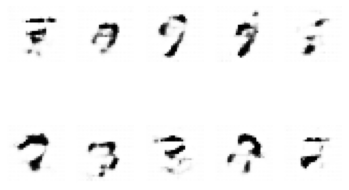

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.90625, 1.0, 0.33984375
1 / 100: 0.953125, 1.0, 0.3203125
2 / 100: 1.0, 0.9921875, 0.29296875
3 / 100: 0.9921875, 0.984375, 0.2890625
4 / 100: 1.0, 0.953125, 0.18359375
5 / 100: 0.9765625, 1.0, 0.17578125
6 / 100: 0.953125, 0.984375, 0.26171875
7 / 100: 0.984375, 0.96875, 0.1875
8 / 100: 0.9921875, 1.0, 0.140625
9 / 100: 0.96875, 0.9921875, 0.1875
10 / 100: 0.9765625, 0.9921875, 0.2421875
11 / 100: 0.9921875, 0.9921875, 0.30078125
12 / 100: 0.9921875, 0.9921875, 0.37890625
13 / 100: 0.9921875, 1.0, 0.421875
14 / 100: 1.0, 1.0, 0.39453125
15 / 100: 1.0, 0.96875, 0.4140625
16 / 100: 0.9921875, 1.0, 0.44140625
17 / 100: 0.953125, 1.0, 0.45703125
18 / 100: 0.9765625, 0.984375, 0.46875
19 / 100: 1.0, 0.984375, 0.38671875
20 / 100: 0.984375, 0.9921875, 0.30859375
21 / 100: 0.9765625, 0.9921875, 0.28515625
22 / 100: 0.9921875, 0.9921875, 0.20703125
23 / 100: 0.96875, 0.9921875, 0.22265625
24 / 100: 1.0, 0.992

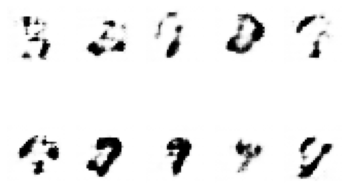

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.953125, 1.0, 0.01171875
1 / 100: 0.8828125, 0.59375, 0.01953125
2 / 100: 0.515625, 0.796875, 0.1875
3 / 100: 0.9765625, 0.9140625, 0.1796875
4 / 100: 0.9375, 0.9453125, 0.1328125
5 / 100: 0.921875, 0.9453125, 0.14453125
6 / 100: 0.8984375, 0.9296875, 0.2421875
7 / 100: 0.9453125, 0.9921875, 0.27734375
8 / 100: 0.96875, 0.9765625, 0.34375
9 / 100: 0.921875, 0.921875, 0.37109375
10 / 100: 0.96875, 0.9765625, 0.40234375
11 / 100: 0.96875, 0.9921875, 0.5
12 / 100: 0.9921875, 0.9921875, 0.609375
13 / 100: 0.953125, 0.984375, 0.6328125
14 / 100: 0.9921875, 0.9765625, 0.64453125
15 / 100: 1.0, 1.0, 0.6015625
16 / 100: 1.0, 0.9765625, 0.68359375
17 / 100: 0.9765625, 0.984375, 0.63671875
18 / 100: 0.9296875, 0.9765625, 0.7421875
19 / 100: 1.0, 0.9609375, 0.66015625
20 / 100: 1.0, 1.0, 0.67578125
21 / 100: 0.9921875, 0.9765625, 0.7109375
22 / 100: 1.0, 0.9765625, 0.71484375
23 / 100: 0.9296875, 0.9765625, 0.761

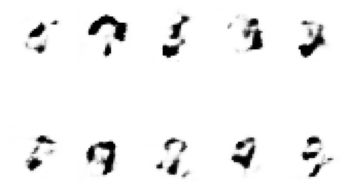

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 0.9921875, 0.96875
1 / 100: 0.9375, 0.9453125, 0.953125
2 / 100: 1.0, 0.984375, 0.9609375
3 / 100: 0.984375, 0.9609375, 0.921875
4 / 100: 0.9375, 0.96875, 0.89453125
5 / 100: 1.0, 0.984375, 0.89453125
6 / 100: 1.0, 1.0, 0.7890625
7 / 100: 0.9921875, 0.9765625, 0.7109375
8 / 100: 0.9765625, 0.890625, 0.78515625
9 / 100: 0.9140625, 0.9921875, 0.84375
10 / 100: 1.0, 1.0, 0.83984375
11 / 100: 1.0, 1.0, 0.87890625
12 / 100: 0.9765625, 0.9609375, 0.67578125
13 / 100: 0.9921875, 1.0, 0.65625
14 / 100: 0.9921875, 0.9921875, 0.50390625
15 / 100: 1.0, 0.9375, 0.3671875
16 / 100: 0.96875, 0.90625, 0.29296875
17 / 100: 0.7734375, 0.9140625, 0.7734375
18 / 100: 0.9453125, 0.9296875, 0.74609375
19 / 100: 0.984375, 0.9765625, 0.671875
20 / 100: 0.96875, 0.953125, 0.640625
21 / 100: 0.6796875, 0.8125, 0.50390625
22 / 100: 0.984375, 1.0, 0.42578125
23 / 100: 0.9609375, 1.0, 0.29296875
24 / 100: 1.0, 0.875, 0.238281

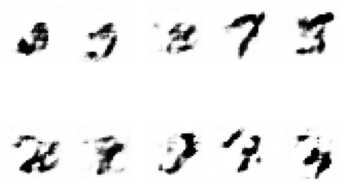

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.984375, 1.0, 0.22265625
1 / 100: 1.0, 1.0, 0.2890625
2 / 100: 1.0, 0.984375, 0.23828125
3 / 100: 1.0, 0.984375, 0.25
4 / 100: 0.984375, 1.0, 0.1015625
5 / 100: 0.984375, 0.9921875, 0.1171875
6 / 100: 1.0, 1.0, 0.1328125
7 / 100: 1.0, 0.9765625, 0.11328125
8 / 100: 1.0, 1.0, 0.1171875
9 / 100: 0.953125, 1.0, 0.28515625
10 / 100: 1.0, 1.0, 0.3125
11 / 100: 1.0, 0.984375, 0.30078125
12 / 100: 0.984375, 0.9375, 0.2265625
13 / 100: 0.9609375, 0.9921875, 0.234375
14 / 100: 0.9921875, 1.0, 0.1640625
15 / 100: 1.0, 0.9140625, 0.1171875
16 / 100: 0.9765625, 1.0, 0.1484375
17 / 100: 0.96875, 1.0, 0.1953125
18 / 100: 0.9921875, 0.984375, 0.18359375
19 / 100: 0.9765625, 1.0, 0.1484375
20 / 100: 1.0, 0.96875, 0.08984375
21 / 100: 0.984375, 0.9453125, 0.05078125
22 / 100: 0.96875, 1.0, 0.05078125
23 / 100: 0.984375, 0.953125, 0.02734375
24 / 100: 0.9765625, 1.0, 0.046875
25 / 100: 0.984375, 0.953125, 0.0390625
26 /

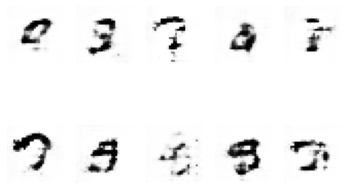

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.9921875, 1.0, 0.44140625
1 / 100: 0.9921875, 1.0, 0.546875
2 / 100: 1.0, 1.0, 0.46484375
3 / 100: 0.9921875, 1.0, 0.4375
4 / 100: 1.0, 1.0, 0.34375
5 / 100: 1.0, 1.0, 0.41015625
6 / 100: 1.0, 0.9921875, 0.43359375
7 / 100: 1.0, 0.9921875, 0.33203125
8 / 100: 0.9921875, 1.0, 0.32421875
9 / 100: 0.984375, 0.9921875, 0.41015625
10 / 100: 1.0, 0.9921875, 0.4140625
11 / 100: 1.0, 0.984375, 0.53515625
12 / 100: 0.9609375, 0.96875, 0.46875
13 / 100: 1.0, 0.96875, 0.55078125
14 / 100: 0.9921875, 1.0, 0.37109375
15 / 100: 0.9765625, 1.0, 0.35546875
16 / 100: 0.9765625, 0.984375, 0.296875
17 / 100: 0.984375, 0.9765625, 0.3359375
18 / 100: 1.0, 1.0, 0.36328125
19 / 100: 0.9609375, 0.9921875, 0.33984375
20 / 100: 0.9921875, 0.984375, 0.3046875
21 / 100: 1.0, 0.9921875, 0.328125
22 / 100: 0.953125, 0.953125, 0.33984375
23 / 100: 0.984375, 1.0, 0.33203125
24 / 100: 0.984375, 0.9921875, 0.3515625
25 / 100: 1.0, 1.0,

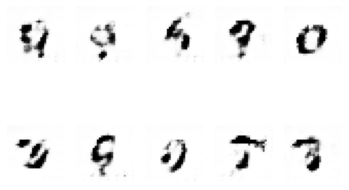

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 0.48828125
1 / 100: 1.0, 1.0, 0.50390625
2 / 100: 1.0, 1.0, 0.46484375
3 / 100: 1.0, 1.0, 0.5703125
4 / 100: 0.9921875, 1.0, 0.56640625
5 / 100: 1.0, 1.0, 0.5390625
6 / 100: 0.9921875, 1.0, 0.58984375
7 / 100: 1.0, 1.0, 0.55078125
8 / 100: 1.0, 1.0, 0.5234375
9 / 100: 1.0, 1.0, 0.5703125
10 / 100: 0.9921875, 1.0, 0.69921875
11 / 100: 1.0, 1.0, 0.6796875
12 / 100: 1.0, 1.0, 0.66796875
13 / 100: 1.0, 1.0, 0.70703125
14 / 100: 1.0, 1.0, 0.6953125
15 / 100: 1.0, 1.0, 0.70703125
16 / 100: 1.0, 1.0, 0.671875
17 / 100: 1.0, 1.0, 0.7109375
18 / 100: 1.0, 1.0, 0.63671875
19 / 100: 1.0, 1.0, 0.6796875
20 / 100: 1.0, 1.0, 0.73046875
21 / 100: 1.0, 1.0, 0.80078125
22 / 100: 1.0, 1.0, 0.75
23 / 100: 1.0, 1.0, 0.78125
24 / 100: 1.0, 1.0, 0.7265625
25 / 100: 1.0, 1.0, 0.7109375
26 / 100: 0.9921875, 1.0, 0.72265625
27 / 100: 1.0, 1.0, 0.72265625
28 / 100: 1.0, 1.0, 0.6953125
29 / 100: 1.0, 1.0, 0.7109375
30 /

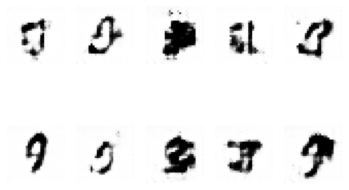

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 0.421875
1 / 100: 0.9921875, 1.0, 0.5078125
2 / 100: 1.0, 1.0, 0.4921875
3 / 100: 1.0, 1.0, 0.44140625
4 / 100: 1.0, 1.0, 0.42578125
5 / 100: 0.9921875, 1.0, 0.4375
6 / 100: 1.0, 1.0, 0.44140625
7 / 100: 1.0, 0.984375, 0.37109375
8 / 100: 0.984375, 1.0, 0.30859375
9 / 100: 1.0, 1.0, 0.34375
10 / 100: 1.0, 1.0, 0.28515625
11 / 100: 1.0, 1.0, 0.30859375
12 / 100: 1.0, 1.0, 0.35546875
13 / 100: 1.0, 1.0, 0.28515625
14 / 100: 1.0, 1.0, 0.2890625
15 / 100: 0.9921875, 1.0, 0.265625
16 / 100: 1.0, 1.0, 0.28515625
17 / 100: 0.9921875, 1.0, 0.25390625
18 / 100: 1.0, 1.0, 0.2421875
19 / 100: 1.0, 1.0, 0.26953125
20 / 100: 1.0, 1.0, 0.2421875
21 / 100: 1.0, 1.0, 0.20703125
22 / 100: 1.0, 1.0, 0.19921875
23 / 100: 1.0, 1.0, 0.1640625
24 / 100: 0.984375, 1.0, 0.1484375
25 / 100: 1.0, 1.0, 0.1328125
26 / 100: 1.0, 1.0, 0.10546875
27 / 100: 1.0, 1.0, 0.109375
28 / 100: 1.0, 1.0, 0.1328125
29 / 100: 1.0, 1.0,

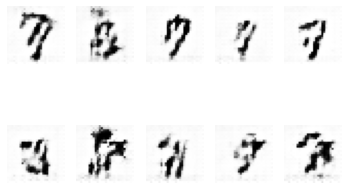

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 0.52734375
1 / 100: 1.0, 1.0, 0.515625
2 / 100: 0.9921875, 1.0, 0.5546875
3 / 100: 1.0, 1.0, 0.546875
4 / 100: 1.0, 1.0, 0.49609375
5 / 100: 1.0, 1.0, 0.625
6 / 100: 1.0, 1.0, 0.640625
7 / 100: 1.0, 1.0, 0.59375
8 / 100: 1.0, 1.0, 0.58203125
9 / 100: 0.9921875, 1.0, 0.55859375
10 / 100: 1.0, 1.0, 0.546875
11 / 100: 1.0, 1.0, 0.54296875
12 / 100: 1.0, 1.0, 0.61328125
13 / 100: 1.0, 1.0, 0.52734375
14 / 100: 1.0, 1.0, 0.57421875
15 / 100: 1.0, 1.0, 0.5703125
16 / 100: 1.0, 1.0, 0.5625
17 / 100: 1.0, 1.0, 0.59375
18 / 100: 1.0, 1.0, 0.5703125
19 / 100: 1.0, 1.0, 0.6484375
20 / 100: 1.0, 1.0, 0.60546875
21 / 100: 1.0, 1.0, 0.578125
22 / 100: 1.0, 1.0, 0.57421875
23 / 100: 1.0, 1.0, 0.5546875
24 / 100: 1.0, 1.0, 0.56640625
25 / 100: 0.9921875, 1.0, 0.515625
26 / 100: 0.9921875, 1.0, 0.59375
27 / 100: 1.0, 1.0, 0.57421875
28 / 100: 0.9921875, 1.0, 0.58203125
29 / 100: 1.0, 1.0, 0.55078125
30 / 100: 

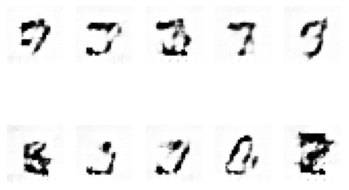

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 0.9921875, 0.36328125
1 / 100: 1.0, 1.0, 0.37890625
2 / 100: 1.0, 1.0, 0.453125
3 / 100: 1.0, 1.0, 0.3984375
4 / 100: 1.0, 1.0, 0.35546875
5 / 100: 1.0, 1.0, 0.4296875
6 / 100: 1.0, 1.0, 0.37109375
7 / 100: 1.0, 1.0, 0.40625
8 / 100: 1.0, 1.0, 0.39453125
9 / 100: 1.0, 1.0, 0.4375
10 / 100: 1.0, 1.0, 0.4453125
11 / 100: 1.0, 1.0, 0.4765625
12 / 100: 1.0, 1.0, 0.39453125
13 / 100: 1.0, 1.0, 0.4375
14 / 100: 1.0, 1.0, 0.41015625
15 / 100: 1.0, 1.0, 0.44140625
16 / 100: 1.0, 1.0, 0.3671875
17 / 100: 1.0, 0.9921875, 0.390625
18 / 100: 1.0, 1.0, 0.3203125
19 / 100: 1.0, 1.0, 0.28125
20 / 100: 1.0, 1.0, 0.30859375
21 / 100: 1.0, 1.0, 0.28125
22 / 100: 1.0, 1.0, 0.28515625
23 / 100: 1.0, 1.0, 0.34375
24 / 100: 1.0, 1.0, 0.328125
25 / 100: 1.0, 1.0, 0.41015625
26 / 100: 1.0, 1.0, 0.30859375
27 / 100: 1.0, 1.0, 0.34765625
28 / 100: 1.0, 1.0, 0.3046875
29 / 100: 1.0, 1.0, 0.296875
30 / 100: 1.0, 0.9765625, 0.

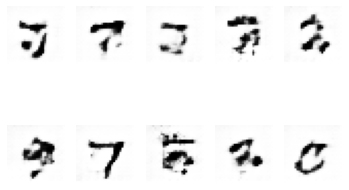

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 0.31640625
1 / 100: 0.9921875, 1.0, 0.3203125
2 / 100: 1.0, 1.0, 0.328125
3 / 100: 1.0, 1.0, 0.37890625
4 / 100: 1.0, 1.0, 0.375
5 / 100: 0.9921875, 1.0, 0.45703125
6 / 100: 1.0, 1.0, 0.375
7 / 100: 1.0, 1.0, 0.4609375
8 / 100: 0.9921875, 1.0, 0.38671875
9 / 100: 0.9921875, 1.0, 0.421875
10 / 100: 1.0, 1.0, 0.50390625
11 / 100: 1.0, 1.0, 0.49609375
12 / 100: 1.0, 1.0, 0.375
13 / 100: 0.9921875, 1.0, 0.375
14 / 100: 0.9921875, 1.0, 0.4140625
15 / 100: 0.9921875, 1.0, 0.3203125
16 / 100: 1.0, 1.0, 0.3125
17 / 100: 1.0, 0.9765625, 0.1875
18 / 100: 0.96875, 1.0, 0.2734375
19 / 100: 0.9921875, 1.0, 0.36328125
20 / 100: 1.0, 0.9921875, 0.3125
21 / 100: 0.9921875, 1.0, 0.4296875
22 / 100: 0.9921875, 1.0, 0.48828125
23 / 100: 1.0, 1.0, 0.515625
24 / 100: 1.0, 0.9921875, 0.4453125
25 / 100: 0.9921875, 1.0, 0.51953125
26 / 100: 1.0, 1.0, 0.5
27 / 100: 0.9921875, 1.0, 0.5625
28 / 100: 1.0, 1.0, 0.6328125

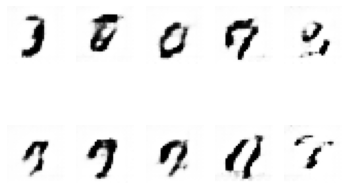

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.9921875, 1.0, 0.29296875
1 / 100: 0.9921875, 1.0, 0.28515625
2 / 100: 0.9921875, 0.984375, 0.30859375
3 / 100: 0.984375, 1.0, 0.4375
4 / 100: 1.0, 1.0, 0.44921875
5 / 100: 0.9765625, 0.9921875, 0.35546875
6 / 100: 0.9765625, 1.0, 0.38671875
7 / 100: 0.9921875, 1.0, 0.3671875
8 / 100: 1.0, 1.0, 0.41015625
9 / 100: 1.0, 1.0, 0.4609375
10 / 100: 1.0, 1.0, 0.51953125
11 / 100: 1.0, 1.0, 0.52734375
12 / 100: 1.0, 1.0, 0.59375
13 / 100: 1.0, 1.0, 0.59375
14 / 100: 1.0, 1.0, 0.58203125
15 / 100: 1.0, 1.0, 0.51171875
16 / 100: 1.0, 1.0, 0.4921875
17 / 100: 0.9921875, 1.0, 0.5390625
18 / 100: 0.9765625, 1.0, 0.4453125
19 / 100: 1.0, 1.0, 0.375
20 / 100: 1.0, 1.0, 0.359375
21 / 100: 0.9921875, 1.0, 0.34765625
22 / 100: 1.0, 1.0, 0.30859375
23 / 100: 1.0, 0.9921875, 0.390625
24 / 100: 1.0, 1.0, 0.5
25 / 100: 0.9921875, 1.0, 0.5234375
26 / 100: 1.0, 1.0, 0.58203125
27 / 100: 1.0, 1.0, 0.484375
28 / 100: 1.0, 1.0,

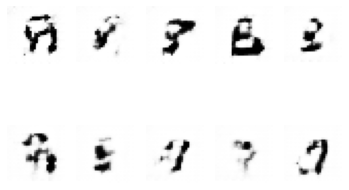

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 0.66796875
1 / 100: 1.0, 1.0, 0.66015625
2 / 100: 1.0, 1.0, 0.6171875
3 / 100: 1.0, 1.0, 0.62109375
4 / 100: 1.0, 1.0, 0.58984375
5 / 100: 1.0, 1.0, 0.5703125
6 / 100: 0.9921875, 1.0, 0.47265625
7 / 100: 1.0, 0.984375, 0.5078125
8 / 100: 1.0, 1.0, 0.421875
9 / 100: 1.0, 1.0, 0.37109375
10 / 100: 1.0, 1.0, 0.28515625
11 / 100: 1.0, 1.0, 0.30078125
12 / 100: 1.0, 1.0, 0.2890625
13 / 100: 1.0, 1.0, 0.26953125
14 / 100: 1.0, 0.9921875, 0.28515625
15 / 100: 0.9921875, 0.9921875, 0.27734375
16 / 100: 0.984375, 1.0, 0.34765625
17 / 100: 1.0, 1.0, 0.26171875
18 / 100: 1.0, 1.0, 0.35546875
19 / 100: 1.0, 1.0, 0.41015625
20 / 100: 0.9921875, 1.0, 0.359375
21 / 100: 0.9921875, 1.0, 0.25390625
22 / 100: 1.0, 0.9921875, 0.234375
23 / 100: 0.9765625, 0.984375, 0.1875
24 / 100: 1.0, 1.0, 0.125
25 / 100: 0.9921875, 1.0, 0.28125
26 / 100: 1.0, 0.9921875, 0.265625
27 / 100: 1.0, 0.984375, 0.1171875
28 / 100: 1.

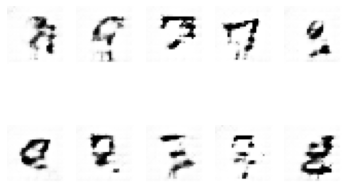

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 0.17578125
1 / 100: 1.0, 1.0, 0.203125
2 / 100: 0.9921875, 1.0, 0.19140625
3 / 100: 1.0, 1.0, 0.19140625
4 / 100: 1.0, 1.0, 0.203125
5 / 100: 0.9921875, 1.0, 0.18359375
6 / 100: 1.0, 1.0, 0.2578125
7 / 100: 1.0, 1.0, 0.29296875
8 / 100: 0.9921875, 1.0, 0.25390625
9 / 100: 0.9921875, 1.0, 0.2265625
10 / 100: 1.0, 1.0, 0.25
11 / 100: 1.0, 1.0, 0.2578125
12 / 100: 0.9921875, 1.0, 0.25
13 / 100: 1.0, 1.0, 0.203125
14 / 100: 1.0, 1.0, 0.23046875
15 / 100: 1.0, 1.0, 0.23046875
16 / 100: 1.0, 1.0, 0.20703125
17 / 100: 1.0, 1.0, 0.21484375
18 / 100: 1.0, 1.0, 0.234375
19 / 100: 1.0, 1.0, 0.265625
20 / 100: 1.0, 1.0, 0.2734375
21 / 100: 1.0, 1.0, 0.3203125
22 / 100: 1.0, 1.0, 0.296875
23 / 100: 1.0, 1.0, 0.3515625
24 / 100: 1.0, 1.0, 0.2734375
25 / 100: 1.0, 1.0, 0.30078125
26 / 100: 1.0, 1.0, 0.359375
27 / 100: 1.0, 1.0, 0.39453125
28 / 100: 1.0, 1.0, 0.3984375
29 / 100: 1.0, 1.0, 0.37109375
30 / 100:

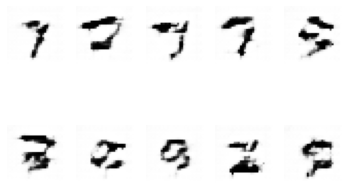

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 0.48046875
1 / 100: 1.0, 1.0, 0.51171875
2 / 100: 0.9921875, 1.0, 0.62109375
3 / 100: 1.0, 1.0, 0.64453125
4 / 100: 1.0, 1.0, 0.671875
5 / 100: 1.0, 1.0, 0.58984375
6 / 100: 1.0, 1.0, 0.66796875
7 / 100: 1.0, 1.0, 0.6328125
8 / 100: 1.0, 1.0, 0.69921875
9 / 100: 1.0, 1.0, 0.66796875
10 / 100: 1.0, 1.0, 0.6875
11 / 100: 1.0, 1.0, 0.671875
12 / 100: 1.0, 1.0, 0.6640625
13 / 100: 1.0, 1.0, 0.65234375
14 / 100: 1.0, 1.0, 0.7109375
15 / 100: 1.0, 1.0, 0.62890625
16 / 100: 1.0, 1.0, 0.609375
17 / 100: 1.0, 1.0, 0.65234375
18 / 100: 1.0, 1.0, 0.640625
19 / 100: 1.0, 1.0, 0.65625
20 / 100: 1.0, 1.0, 0.640625
21 / 100: 1.0, 1.0, 0.6484375
22 / 100: 1.0, 1.0, 0.63671875
23 / 100: 1.0, 1.0, 0.53125
24 / 100: 1.0, 1.0, 0.58984375
25 / 100: 1.0, 1.0, 0.61328125
26 / 100: 1.0, 1.0, 0.56640625
27 / 100: 0.9921875, 1.0, 0.62890625
28 / 100: 0.9921875, 1.0, 0.72265625
29 / 100: 1.0, 1.0, 0.75390625
30 / 100: 1

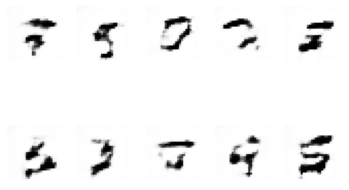

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.9453125, 0.671875, 0.578125
1 / 100: 0.0390625, 0.0, 0.078125
2 / 100: 1.0, 1.0, 0.046875
3 / 100: 0.3046875, 1.0, 0.12109375
4 / 100: 1.0, 1.0, 0.1796875
5 / 100: 1.0, 1.0, 0.19140625
6 / 100: 1.0, 1.0, 0.2421875
7 / 100: 1.0, 1.0, 0.29296875
8 / 100: 1.0, 1.0, 0.26171875
9 / 100: 1.0, 1.0, 0.32421875
10 / 100: 1.0, 1.0, 0.31640625
11 / 100: 1.0, 1.0, 0.31640625
12 / 100: 1.0, 1.0, 0.3125
13 / 100: 1.0, 1.0, 0.3515625
14 / 100: 1.0, 1.0, 0.29296875
15 / 100: 1.0, 1.0, 0.33203125
16 / 100: 1.0, 1.0, 0.36328125
17 / 100: 1.0, 1.0, 0.26171875
18 / 100: 1.0, 1.0, 0.30859375
19 / 100: 1.0, 1.0, 0.26953125
20 / 100: 1.0, 1.0, 0.3203125
21 / 100: 1.0, 1.0, 0.25390625
22 / 100: 1.0, 1.0, 0.26171875
23 / 100: 1.0, 1.0, 0.265625
24 / 100: 1.0, 1.0, 0.21484375
25 / 100: 1.0, 1.0, 0.19921875
26 / 100: 1.0, 1.0, 0.19140625
27 / 100: 1.0, 1.0, 0.15625
28 / 100: 1.0, 1.0, 0.1484375
29 / 100: 1.0, 1.0, 0.125
30 / 10

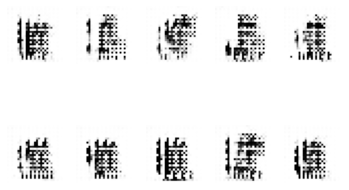

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.9921875, 0.9921875, 0.22265625
1 / 100: 1.0, 1.0, 0.140625
2 / 100: 1.0, 1.0, 0.16015625
3 / 100: 1.0, 1.0, 0.13671875
4 / 100: 1.0, 1.0, 0.109375
5 / 100: 1.0, 1.0, 0.08984375
6 / 100: 1.0, 1.0, 0.15625
7 / 100: 1.0, 1.0, 0.13671875
8 / 100: 1.0, 1.0, 0.12890625
9 / 100: 1.0, 1.0, 0.1171875
10 / 100: 1.0, 1.0, 0.14453125
11 / 100: 1.0, 1.0, 0.109375
12 / 100: 1.0, 1.0, 0.078125
13 / 100: 1.0, 1.0, 0.1015625
14 / 100: 1.0, 1.0, 0.1015625
15 / 100: 1.0, 1.0, 0.0703125
16 / 100: 1.0, 1.0, 0.08203125
17 / 100: 1.0, 1.0, 0.1015625
18 / 100: 1.0, 1.0, 0.0859375
19 / 100: 1.0, 1.0, 0.08984375
20 / 100: 1.0, 1.0, 0.0859375
21 / 100: 1.0, 1.0, 0.09765625
22 / 100: 1.0, 1.0, 0.09765625
23 / 100: 1.0, 1.0, 0.09765625
24 / 100: 1.0, 1.0, 0.07421875
25 / 100: 1.0, 1.0, 0.1015625
26 / 100: 1.0, 1.0, 0.0859375
27 / 100: 1.0, 1.0, 0.09765625
28 / 100: 1.0, 1.0, 0.1171875
29 / 100: 1.0, 1.0, 0.06640625
30 / 100: 1.0,

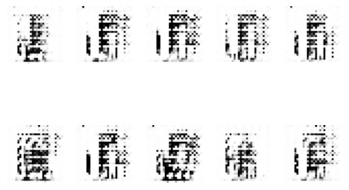

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 0.265625
1 / 100: 1.0, 1.0, 0.1796875
2 / 100: 1.0, 1.0, 0.21484375
3 / 100: 1.0, 1.0, 0.21484375
4 / 100: 1.0, 1.0, 0.22265625
5 / 100: 1.0, 1.0, 0.23046875
6 / 100: 1.0, 1.0, 0.2109375
7 / 100: 1.0, 1.0, 0.17578125
8 / 100: 1.0, 1.0, 0.1875
9 / 100: 1.0, 1.0, 0.203125
10 / 100: 1.0, 1.0, 0.21875
11 / 100: 1.0, 1.0, 0.23828125
12 / 100: 1.0, 1.0, 0.25390625
13 / 100: 1.0, 1.0, 0.20703125
14 / 100: 1.0, 1.0, 0.203125
15 / 100: 1.0, 1.0, 0.17578125
16 / 100: 1.0, 1.0, 0.19140625
17 / 100: 1.0, 1.0, 0.19140625
18 / 100: 1.0, 1.0, 0.16796875
19 / 100: 1.0, 1.0, 0.21875
20 / 100: 1.0, 1.0, 0.1796875
21 / 100: 1.0, 1.0, 0.1796875
22 / 100: 1.0, 1.0, 0.23828125
23 / 100: 1.0, 1.0, 0.2109375
24 / 100: 1.0, 1.0, 0.234375
25 / 100: 1.0, 1.0, 0.234375
26 / 100: 1.0, 1.0, 0.2265625
27 / 100: 1.0, 1.0, 0.2265625
28 / 100: 1.0, 1.0, 0.1796875
29 / 100: 1.0, 1.0, 0.23828125
30 / 100: 1.0, 1.0, 0.23828125
31

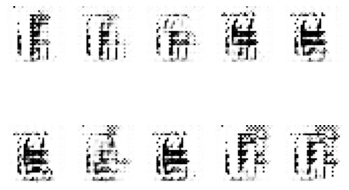

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 0.11328125
1 / 100: 1.0, 1.0, 0.0859375
2 / 100: 1.0, 1.0, 0.11328125
3 / 100: 1.0, 1.0, 0.109375
4 / 100: 1.0, 1.0, 0.15234375
5 / 100: 1.0, 1.0, 0.1015625
6 / 100: 1.0, 1.0, 0.109375
7 / 100: 1.0, 1.0, 0.10546875
8 / 100: 1.0, 1.0, 0.11328125
9 / 100: 1.0, 1.0, 0.12109375
10 / 100: 1.0, 1.0, 0.125
11 / 100: 1.0, 1.0, 0.09375
12 / 100: 1.0, 1.0, 0.11328125
13 / 100: 1.0, 1.0, 0.11328125
14 / 100: 1.0, 1.0, 0.1484375
15 / 100: 1.0, 1.0, 0.13671875
16 / 100: 1.0, 1.0, 0.140625
17 / 100: 1.0, 1.0, 0.12109375
18 / 100: 1.0, 1.0, 0.15625
19 / 100: 1.0, 1.0, 0.11328125
20 / 100: 1.0, 1.0, 0.13671875
21 / 100: 1.0, 1.0, 0.13671875
22 / 100: 1.0, 1.0, 0.109375
23 / 100: 1.0, 1.0, 0.140625
24 / 100: 1.0, 1.0, 0.11328125
25 / 100: 1.0, 1.0, 0.15234375
26 / 100: 1.0, 1.0, 0.15625
27 / 100: 1.0, 1.0, 0.1484375
28 / 100: 1.0, 1.0, 0.11328125
29 / 100: 1.0, 1.0, 0.12890625
30 / 100: 1.0, 1.0, 0.1875
31 / 1

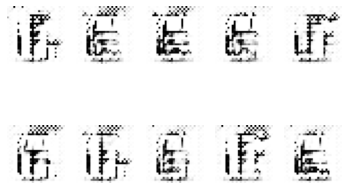

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 0.1171875
1 / 100: 1.0, 1.0, 0.109375
2 / 100: 1.0, 1.0, 0.14453125
3 / 100: 1.0, 1.0, 0.1015625
4 / 100: 1.0, 1.0, 0.1171875
5 / 100: 1.0, 1.0, 0.10546875
6 / 100: 1.0, 1.0, 0.14453125
7 / 100: 1.0, 1.0, 0.12890625
8 / 100: 1.0, 1.0, 0.125
9 / 100: 1.0, 1.0, 0.13671875
10 / 100: 1.0, 1.0, 0.109375
11 / 100: 1.0, 1.0, 0.125
12 / 100: 1.0, 1.0, 0.109375
13 / 100: 1.0, 1.0, 0.11328125
14 / 100: 1.0, 1.0, 0.1015625
15 / 100: 1.0, 1.0, 0.13671875
16 / 100: 1.0, 1.0, 0.125
17 / 100: 1.0, 1.0, 0.11328125
18 / 100: 1.0, 1.0, 0.15625
19 / 100: 1.0, 1.0, 0.11328125
20 / 100: 1.0, 1.0, 0.125
21 / 100: 1.0, 1.0, 0.140625
22 / 100: 1.0, 1.0, 0.13671875
23 / 100: 1.0, 1.0, 0.15234375
24 / 100: 1.0, 1.0, 0.18359375
25 / 100: 1.0, 1.0, 0.12890625
26 / 100: 1.0, 1.0, 0.19140625
27 / 100: 1.0, 1.0, 0.140625
28 / 100: 1.0, 1.0, 0.15625
29 / 100: 1.0, 1.0, 0.125
30 / 100: 1.0, 1.0, 0.12109375
31 / 100: 1.0, 1.0,

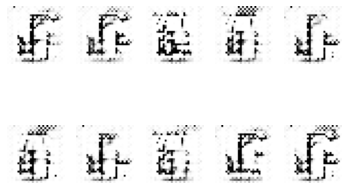

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 0.21875
1 / 100: 1.0, 1.0, 0.19921875
2 / 100: 1.0, 1.0, 0.21484375
3 / 100: 1.0, 1.0, 0.18359375
4 / 100: 1.0, 1.0, 0.2109375
5 / 100: 1.0, 1.0, 0.1640625
6 / 100: 1.0, 1.0, 0.22265625
7 / 100: 1.0, 1.0, 0.24609375
8 / 100: 1.0, 1.0, 0.20703125
9 / 100: 1.0, 1.0, 0.1953125
10 / 100: 1.0, 1.0, 0.18359375
11 / 100: 1.0, 1.0, 0.203125
12 / 100: 1.0, 1.0, 0.2421875
13 / 100: 1.0, 1.0, 0.171875
14 / 100: 1.0, 1.0, 0.1953125
15 / 100: 1.0, 1.0, 0.171875
16 / 100: 1.0, 1.0, 0.17578125
17 / 100: 1.0, 1.0, 0.1875
18 / 100: 1.0, 1.0, 0.23046875
19 / 100: 1.0, 1.0, 0.22265625
20 / 100: 1.0, 1.0, 0.21484375
21 / 100: 1.0, 1.0, 0.1796875
22 / 100: 1.0, 1.0, 0.203125
23 / 100: 1.0, 1.0, 0.23046875
24 / 100: 1.0, 1.0, 0.203125
25 / 100: 1.0, 1.0, 0.21484375
26 / 100: 1.0, 1.0, 0.20703125
27 / 100: 1.0, 1.0, 0.20703125
28 / 100: 1.0, 1.0, 0.20703125
29 / 100: 1.0, 1.0, 0.16796875
30 / 100: 1.0, 1.0, 0.195312

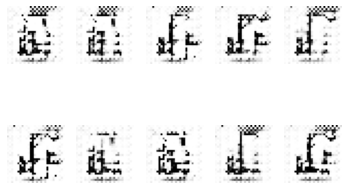

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 0.28125
1 / 100: 1.0, 1.0, 0.25
2 / 100: 1.0, 1.0, 0.25390625
3 / 100: 1.0, 1.0, 0.203125
4 / 100: 1.0, 1.0, 0.2265625
5 / 100: 1.0, 1.0, 0.19140625
6 / 100: 1.0, 1.0, 0.19921875
7 / 100: 1.0, 1.0, 0.2265625
8 / 100: 1.0, 1.0, 0.15625
9 / 100: 1.0, 1.0, 0.203125
10 / 100: 1.0, 1.0, 0.234375
11 / 100: 1.0, 1.0, 0.22265625
12 / 100: 1.0, 1.0, 0.19140625
13 / 100: 1.0, 1.0, 0.24609375
14 / 100: 1.0, 1.0, 0.21484375
15 / 100: 1.0, 1.0, 0.21484375
16 / 100: 1.0, 1.0, 0.234375
17 / 100: 1.0, 1.0, 0.22265625
18 / 100: 1.0, 1.0, 0.2421875
19 / 100: 1.0, 1.0, 0.24609375
20 / 100: 1.0, 1.0, 0.17578125
21 / 100: 1.0, 1.0, 0.1953125
22 / 100: 1.0, 1.0, 0.22265625
23 / 100: 1.0, 1.0, 0.23046875
24 / 100: 1.0, 1.0, 0.25
25 / 100: 1.0, 1.0, 0.20703125
26 / 100: 1.0, 1.0, 0.1796875
27 / 100: 1.0, 1.0, 0.23828125
28 / 100: 1.0, 1.0, 0.19140625
29 / 100: 1.0, 1.0, 0.1953125
30 / 100: 1.0, 1.0, 0.1640625
31 / 10

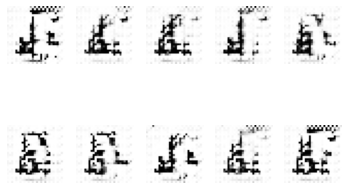

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 0.140625
1 / 100: 1.0, 1.0, 0.19140625
2 / 100: 1.0, 1.0, 0.171875
3 / 100: 0.9921875, 1.0, 0.23046875
4 / 100: 1.0, 1.0, 0.16796875
5 / 100: 1.0, 1.0, 0.19140625
6 / 100: 1.0, 1.0, 0.171875
7 / 100: 1.0, 1.0, 0.17578125
8 / 100: 1.0, 1.0, 0.16796875
9 / 100: 1.0, 1.0, 0.1875
10 / 100: 1.0, 1.0, 0.2265625
11 / 100: 1.0, 1.0, 0.203125
12 / 100: 1.0, 1.0, 0.25390625
13 / 100: 1.0, 1.0, 0.19921875
14 / 100: 1.0, 1.0, 0.23046875
15 / 100: 1.0, 1.0, 0.19921875
16 / 100: 1.0, 1.0, 0.22265625
17 / 100: 1.0, 1.0, 0.1953125
18 / 100: 1.0, 1.0, 0.1953125
19 / 100: 1.0, 1.0, 0.2265625
20 / 100: 1.0, 1.0, 0.1875
21 / 100: 1.0, 1.0, 0.25390625
22 / 100: 1.0, 1.0, 0.26171875
23 / 100: 1.0, 1.0, 0.21875
24 / 100: 1.0, 1.0, 0.2421875
25 / 100: 1.0, 1.0, 0.25390625
26 / 100: 1.0, 1.0, 0.25
27 / 100: 1.0, 1.0, 0.1875
28 / 100: 1.0, 1.0, 0.22265625
29 / 100: 1.0, 1.0, 0.1796875
30 / 100: 1.0, 1.0, 0.1796875
31 /

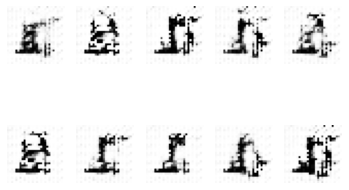

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 0.9921875, 1.0, 0.25
1 / 100: 1.0, 1.0, 0.33984375
2 / 100: 1.0, 1.0, 0.32421875
3 / 100: 1.0, 1.0, 0.328125
4 / 100: 1.0, 1.0, 0.37109375
5 / 100: 1.0, 1.0, 0.36328125
6 / 100: 1.0, 1.0, 0.28125
7 / 100: 1.0, 1.0, 0.32421875
8 / 100: 1.0, 1.0, 0.30078125
9 / 100: 1.0, 1.0, 0.2421875
10 / 100: 1.0, 1.0, 0.30859375
11 / 100: 1.0, 1.0, 0.265625
12 / 100: 1.0, 1.0, 0.34375
13 / 100: 1.0, 0.9921875, 0.24609375
14 / 100: 1.0, 1.0, 0.2734375
15 / 100: 1.0, 1.0, 0.28125
16 / 100: 1.0, 1.0, 0.30859375
17 / 100: 1.0, 1.0, 0.2265625
18 / 100: 1.0, 1.0, 0.265625
19 / 100: 1.0, 1.0, 0.26171875
20 / 100: 1.0, 1.0, 0.34375
21 / 100: 1.0, 1.0, 0.25390625
22 / 100: 1.0, 1.0, 0.28515625
23 / 100: 1.0, 1.0, 0.28515625
24 / 100: 1.0, 1.0, 0.28125
25 / 100: 1.0, 1.0, 0.25390625
26 / 100: 1.0, 1.0, 0.3125
27 / 100: 1.0, 1.0, 0.24609375
28 / 100: 1.0, 1.0, 0.35546875
29 / 100: 1.0, 1.0, 0.32421875
30 / 100: 1.0, 1.0, 0.34765

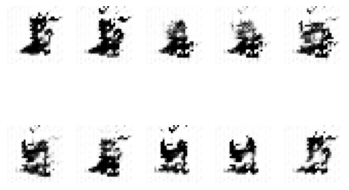

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 0.22265625
1 / 100: 1.0, 1.0, 0.234375
2 / 100: 1.0, 1.0, 0.2421875
3 / 100: 1.0, 1.0, 0.2734375
4 / 100: 1.0, 1.0, 0.22265625
5 / 100: 1.0, 1.0, 0.26171875
6 / 100: 1.0, 1.0, 0.2421875
7 / 100: 1.0, 1.0, 0.23828125
8 / 100: 1.0, 1.0, 0.23828125
9 / 100: 1.0, 1.0, 0.21484375
10 / 100: 1.0, 1.0, 0.26171875
11 / 100: 1.0, 1.0, 0.21484375
12 / 100: 1.0, 1.0, 0.2265625
13 / 100: 1.0, 1.0, 0.171875
14 / 100: 1.0, 0.9921875, 0.15234375
15 / 100: 1.0, 1.0, 0.140625
16 / 100: 1.0, 1.0, 0.13671875
17 / 100: 0.9921875, 1.0, 0.15234375
18 / 100: 1.0, 1.0, 0.08203125
19 / 100: 0.9921875, 1.0, 0.0859375
20 / 100: 1.0, 1.0, 0.15234375
21 / 100: 1.0, 1.0, 0.12890625
22 / 100: 1.0, 1.0, 0.12109375
23 / 100: 1.0, 1.0, 0.1484375
24 / 100: 1.0, 1.0, 0.15234375
25 / 100: 1.0, 1.0, 0.11328125
26 / 100: 1.0, 1.0, 0.08984375
27 / 100: 1.0, 1.0, 0.13671875
28 / 100: 1.0, 1.0, 0.1015625
29 / 100: 1.0, 1.0, 0.09765625


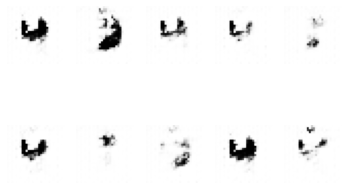

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 0.7421875
1 / 100: 1.0, 1.0, 0.71875
2 / 100: 1.0, 1.0, 0.60546875
3 / 100: 1.0, 1.0, 0.69921875
4 / 100: 1.0, 1.0, 0.70703125
5 / 100: 1.0, 1.0, 0.75
6 / 100: 1.0, 1.0, 0.7421875
7 / 100: 1.0, 1.0, 0.76171875
8 / 100: 1.0, 1.0, 0.75
9 / 100: 1.0, 1.0, 0.76953125
10 / 100: 1.0, 1.0, 0.74609375
11 / 100: 1.0, 1.0, 0.80078125
12 / 100: 1.0, 1.0, 0.8359375
13 / 100: 1.0, 1.0, 0.82421875
14 / 100: 1.0, 1.0, 0.82421875
15 / 100: 1.0, 1.0, 0.80859375
16 / 100: 1.0, 1.0, 0.84375
17 / 100: 1.0, 1.0, 0.77734375
18 / 100: 1.0, 1.0, 0.84375
19 / 100: 1.0, 1.0, 0.84375
20 / 100: 1.0, 1.0, 0.7890625
21 / 100: 1.0, 1.0, 0.80859375
22 / 100: 1.0, 1.0, 0.81640625
23 / 100: 1.0, 1.0, 0.84765625
24 / 100: 1.0, 1.0, 0.8828125
25 / 100: 1.0, 1.0, 0.85546875
26 / 100: 1.0, 1.0, 0.828125
27 / 100: 1.0, 1.0, 0.8359375
28 / 100: 1.0, 1.0, 0.87109375
29 / 100: 0.9921875, 1.0, 0.84765625
30 / 100: 1.0, 1.0, 0.8671875
3

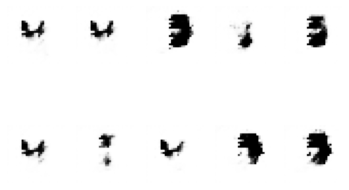

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 0.88671875
1 / 100: 1.0, 1.0, 0.90625
2 / 100: 1.0, 1.0, 0.90625
3 / 100: 1.0, 1.0, 0.859375
4 / 100: 1.0, 1.0, 0.86328125
5 / 100: 1.0, 1.0, 0.93359375
6 / 100: 1.0, 1.0, 0.9140625
7 / 100: 1.0, 1.0, 0.89453125
8 / 100: 1.0, 1.0, 0.90625
9 / 100: 1.0, 1.0, 0.890625
10 / 100: 1.0, 1.0, 0.875
11 / 100: 1.0, 1.0, 0.890625
12 / 100: 1.0, 1.0, 0.8671875
13 / 100: 1.0, 1.0, 0.8515625
14 / 100: 1.0, 1.0, 0.875
15 / 100: 1.0, 1.0, 0.89453125
16 / 100: 1.0, 1.0, 0.890625
17 / 100: 1.0, 1.0, 0.85546875
18 / 100: 1.0, 1.0, 0.89453125
19 / 100: 1.0, 1.0, 0.875
20 / 100: 0.9921875, 1.0, 0.89453125
21 / 100: 1.0, 1.0, 0.90234375
22 / 100: 1.0, 1.0, 0.88671875
23 / 100: 1.0, 1.0, 0.93359375
24 / 100: 1.0, 1.0, 0.9140625
25 / 100: 1.0, 1.0, 0.8984375
26 / 100: 1.0, 1.0, 0.87890625
27 / 100: 1.0, 1.0, 0.8984375
28 / 100: 1.0, 1.0, 0.84765625
29 / 100: 1.0, 1.0, 0.91015625
30 / 100: 1.0, 1.0, 0.84375
31 / 100:

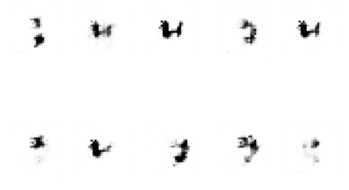

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 0.76171875
1 / 100: 1.0, 1.0, 0.8046875
2 / 100: 1.0, 1.0, 0.75
3 / 100: 1.0, 1.0, 0.7734375
4 / 100: 1.0, 1.0, 0.671875
5 / 100: 1.0, 1.0, 0.66796875
6 / 100: 0.9921875, 1.0, 0.83203125
7 / 100: 1.0, 1.0, 0.8828125
8 / 100: 1.0, 1.0, 0.8984375
9 / 100: 1.0, 1.0, 0.921875
10 / 100: 1.0, 1.0, 0.90625
11 / 100: 1.0, 1.0, 0.9296875
12 / 100: 1.0, 1.0, 0.89453125
13 / 100: 1.0, 1.0, 0.9296875
14 / 100: 1.0, 1.0, 0.92578125
15 / 100: 1.0, 1.0, 0.859375
16 / 100: 1.0, 1.0, 0.91015625
17 / 100: 1.0, 1.0, 0.93359375
18 / 100: 1.0, 1.0, 0.9375
19 / 100: 1.0, 1.0, 0.90625
20 / 100: 1.0, 1.0, 0.890625
21 / 100: 1.0, 1.0, 0.921875
22 / 100: 1.0, 1.0, 0.91796875
23 / 100: 1.0, 1.0, 0.9375
24 / 100: 1.0, 1.0, 0.9453125
25 / 100: 1.0, 1.0, 0.953125
26 / 100: 1.0, 1.0, 0.94140625
27 / 100: 1.0, 1.0, 0.94140625
28 / 100: 1.0, 1.0, 0.91015625
29 / 100: 1.0, 1.0, 0.91015625
30 / 100: 1.0, 1.0, 0.97265625
31 / 10

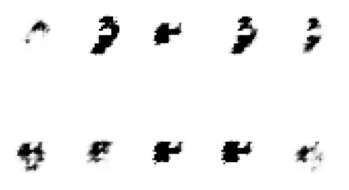

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 0.69140625
1 / 100: 1.0, 1.0, 0.55078125
2 / 100: 1.0, 1.0, 0.5
3 / 100: 1.0, 1.0, 0.46875
4 / 100: 1.0, 1.0, 0.44921875
5 / 100: 1.0, 1.0, 0.375
6 / 100: 1.0, 1.0, 0.390625
7 / 100: 1.0, 1.0, 0.44140625
8 / 100: 1.0, 1.0, 0.44921875
9 / 100: 1.0, 1.0, 0.40625
10 / 100: 1.0, 1.0, 0.41796875
11 / 100: 1.0, 1.0, 0.3828125
12 / 100: 1.0, 1.0, 0.515625
13 / 100: 1.0, 1.0, 0.5234375
14 / 100: 1.0, 1.0, 0.49609375
15 / 100: 1.0, 1.0, 0.4765625
16 / 100: 1.0, 1.0, 0.4453125
17 / 100: 1.0, 1.0, 0.46484375
18 / 100: 1.0, 1.0, 0.43359375
19 / 100: 1.0, 1.0, 0.51953125
20 / 100: 1.0, 1.0, 0.46484375
21 / 100: 1.0, 1.0, 0.52734375
22 / 100: 1.0, 1.0, 0.5703125
23 / 100: 0.9921875, 1.0, 0.89453125
24 / 100: 1.0, 1.0, 0.90234375
25 / 100: 1.0, 1.0, 0.9375
26 / 100: 1.0, 1.0, 0.95703125
27 / 100: 1.0, 1.0, 0.921875
28 / 100: 1.0, 1.0, 0.94140625
29 / 100: 1.0, 1.0, 0.87109375
30 / 100: 1.0, 1.0, 0.9375
31 / 

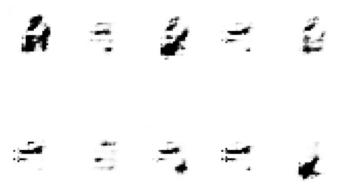

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 0.94140625
1 / 100: 1.0, 1.0, 0.94921875
2 / 100: 1.0, 1.0, 0.9453125
3 / 100: 1.0, 1.0, 0.9609375
4 / 100: 1.0, 1.0, 0.9609375
5 / 100: 1.0, 1.0, 0.93359375
6 / 100: 1.0, 1.0, 0.96875
7 / 100: 1.0, 1.0, 0.9609375
8 / 100: 1.0, 1.0, 0.9453125
9 / 100: 1.0, 1.0, 0.94140625
10 / 100: 1.0, 1.0, 0.9296875
11 / 100: 1.0, 1.0, 0.90234375
12 / 100: 1.0, 1.0, 0.9296875
13 / 100: 1.0, 1.0, 0.91796875
14 / 100: 1.0, 1.0, 0.91015625
15 / 100: 1.0, 1.0, 0.93359375
16 / 100: 0.9921875, 1.0, 0.92578125
17 / 100: 1.0, 1.0, 0.87109375
18 / 100: 1.0, 1.0, 0.84375
19 / 100: 1.0, 1.0, 0.84375
20 / 100: 1.0, 1.0, 0.8515625
21 / 100: 1.0, 1.0, 0.8671875
22 / 100: 1.0, 1.0, 0.828125
23 / 100: 1.0, 1.0, 0.859375
24 / 100: 1.0, 1.0, 0.85546875
25 / 100: 1.0, 1.0, 0.84765625
26 / 100: 1.0, 1.0, 0.83203125
27 / 100: 1.0, 1.0, 0.84765625
28 / 100: 1.0, 1.0, 0.84765625
29 / 100: 1.0, 1.0, 0.8203125
30 / 100: 1.0, 1.0, 0.

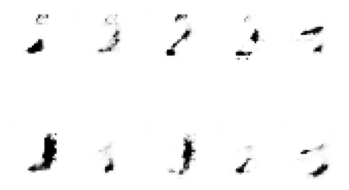

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 0.984375
1 / 100: 1.0, 1.0, 0.9765625
2 / 100: 1.0, 1.0, 0.96875
3 / 100: 1.0, 1.0, 0.98828125
4 / 100: 1.0, 1.0, 0.9609375
5 / 100: 1.0, 1.0, 0.96875
6 / 100: 1.0, 1.0, 0.9609375
7 / 100: 0.9921875, 1.0, 0.98046875
8 / 100: 1.0, 1.0, 0.9765625
9 / 100: 1.0, 1.0, 0.984375
10 / 100: 1.0, 1.0, 0.9921875
11 / 100: 1.0, 1.0, 0.98828125
12 / 100: 1.0, 1.0, 0.9921875
13 / 100: 1.0, 1.0, 1.0
14 / 100: 1.0, 1.0, 1.0
15 / 100: 1.0, 1.0, 0.98046875
16 / 100: 1.0, 1.0, 0.98828125
17 / 100: 1.0, 1.0, 0.984375
18 / 100: 1.0, 1.0, 0.98828125
19 / 100: 1.0, 1.0, 0.984375
20 / 100: 1.0, 1.0, 0.98046875
21 / 100: 1.0, 1.0, 0.9921875
22 / 100: 1.0, 1.0, 0.984375
23 / 100: 1.0, 1.0, 0.984375
24 / 100: 1.0, 1.0, 0.98828125
25 / 100: 1.0, 1.0, 0.98828125
26 / 100: 1.0, 1.0, 0.98828125
27 / 100: 1.0, 1.0, 0.9765625
28 / 100: 1.0, 1.0, 0.97265625
29 / 100: 1.0, 1.0, 0.984375
30 / 100: 1.0, 1.0, 0.98046875
31 / 100: 

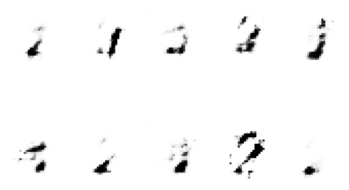

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 0.9609375
1 / 100: 1.0, 1.0, 0.98828125
2 / 100: 1.0, 1.0, 0.9921875
3 / 100: 1.0, 1.0, 0.9765625
4 / 100: 1.0, 1.0, 0.984375
5 / 100: 1.0, 1.0, 0.96484375
6 / 100: 1.0, 1.0, 0.96875
7 / 100: 1.0, 1.0, 0.9609375
8 / 100: 1.0, 1.0, 0.96875
9 / 100: 1.0, 1.0, 0.97265625
10 / 100: 1.0, 1.0, 0.9453125
11 / 100: 1.0, 1.0, 0.94140625
12 / 100: 1.0, 1.0, 0.953125
13 / 100: 1.0, 1.0, 0.953125
14 / 100: 1.0, 1.0, 0.95703125
15 / 100: 1.0, 1.0, 0.98828125
16 / 100: 1.0, 1.0, 0.9765625
17 / 100: 1.0, 1.0, 0.96875
18 / 100: 1.0, 1.0, 0.95703125
19 / 100: 1.0, 1.0, 0.9453125
20 / 100: 1.0, 1.0, 0.984375
21 / 100: 1.0, 1.0, 0.98828125
22 / 100: 1.0, 1.0, 0.984375
23 / 100: 1.0, 1.0, 0.96484375
24 / 100: 1.0, 1.0, 0.97265625
25 / 100: 1.0, 1.0, 0.9453125
26 / 100: 1.0, 1.0, 0.9609375
27 / 100: 1.0, 1.0, 0.99609375
28 / 100: 1.0, 1.0, 0.98046875
29 / 100: 1.0, 1.0, 0.96484375
30 / 100: 1.0, 1.0, 0.96484375
31

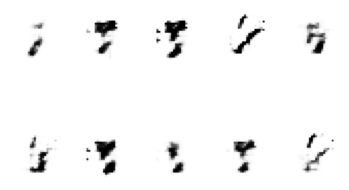

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
0 / 100: 1.0, 1.0, 0.9609375
1 / 100: 1.0, 1.0, 0.953125
2 / 100: 1.0, 1.0, 0.953125
3 / 100: 1.0, 1.0, 0.9453125
4 / 100: 1.0, 1.0, 0.94921875
5 / 100: 1.0, 1.0, 0.97265625
6 / 100: 1.0, 1.0, 0.9609375
7 / 100: 1.0, 1.0, 0.9609375
8 / 100: 1.0, 1.0, 0.97265625
9 / 100: 1.0, 1.0, 0.95703125
10 / 100: 1.0, 1.0, 0.9609375
11 / 100: 1.0, 1.0, 0.97265625
12 / 100: 1.0, 1.0, 0.95703125
13 / 100: 1.0, 1.0, 0.984375
14 / 100: 1.0, 1.0, 0.9609375
15 / 100: 1.0, 1.0, 0.96875
16 / 100: 1.0, 1.0, 0.97265625
17 / 100: 1.0, 1.0, 0.96484375
18 / 100: 1.0, 1.0, 0.95703125
19 / 100: 1.0, 1.0, 0.9765625
20 / 100: 1.0, 1.0, 0.96484375
21 / 100: 1.0, 1.0, 0.921875
22 / 100: 1.0, 1.0, 0.9375
23 / 100: 1.0, 1.0, 0.96484375
24 / 100: 1.0, 1.0, 0.953125
25 / 100: 1.0, 1.0, 0.94140625
26 / 100: 1.0, 1.0, 0.95703125
27 / 100: 1.0, 1.0, 0.94921875
28 / 100: 1.0, 1.0, 0.94921875
29 / 100: 1.0, 1.0, 0.953125
30 / 100: 1.0, 1.0, 0.96484375


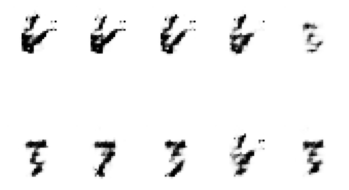

In [10]:
EVALUATION_ROUNDS = 50
BATCHES = 100
BATCH_SIZE = 256

# Lets get fresh copies of everything.
discriminator = create_discriminator(INPUT_SHAPE)
generator = create_generator(NOISE_DIM, DENSE_LAYER_SIZE)
gan = create_gan(generator, discriminator)

for i in range(EVALUATION_ROUNDS):
    train_gan(gan, generator, discriminator, NOISE_DIM, BATCHES, BATCH_SIZE)
    print(f'After {(i+1)*BATCHES*BATCH_SIZE} samples:')
    
    # To evaluate, we'll look at 10 randomly generated samples.
    fake_images, _ = generate_fake_batch(generator, NOISE_DIM, 10)

    for i in range(10):
        ax = plt.subplot(2, 5, i+1)
        ax.axis('off')
        plt.imshow(fake_images[i, :, :, 0], cmap='Greys')

    plt.show()

Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 25600 samples:


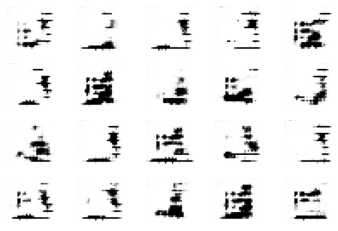


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 51200 samples:


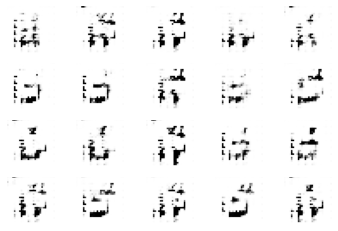


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 76800 samples:


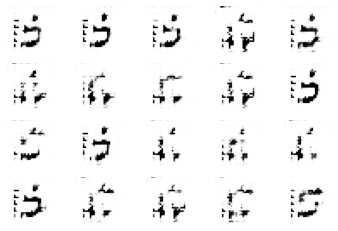


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 102400 samples:


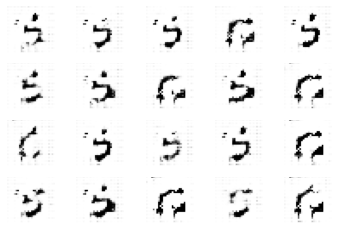


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 128000 samples:


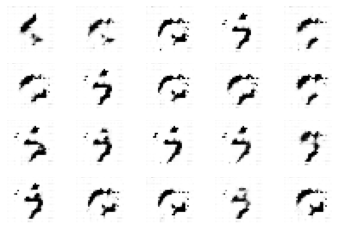


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 153600 samples:


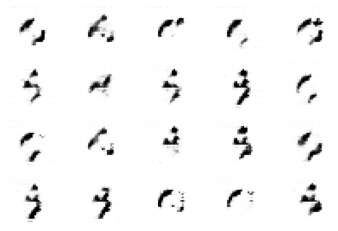


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 179200 samples:


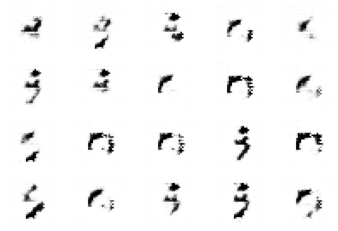


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 204800 samples:


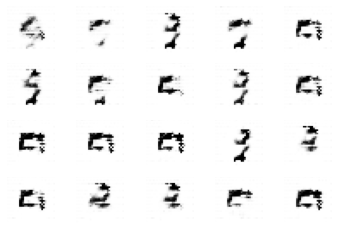


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 230400 samples:


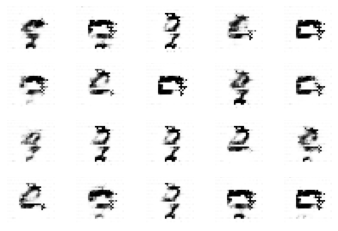


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 256000 samples:


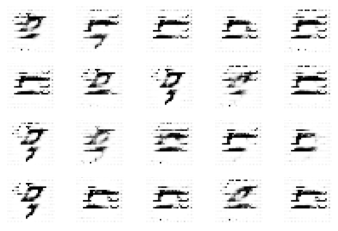


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 281600 samples:


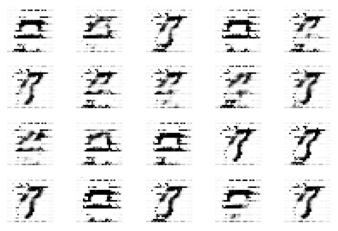


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 307200 samples:


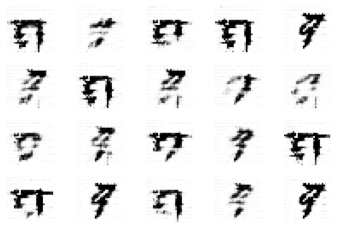


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 332800 samples:


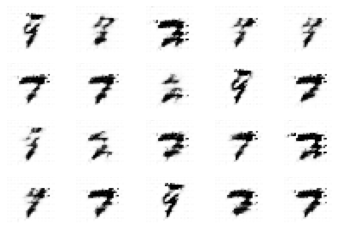


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 358400 samples:


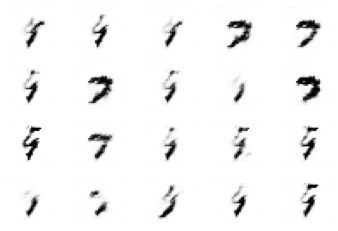


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 384000 samples:


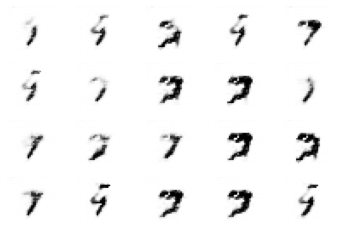


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 409600 samples:


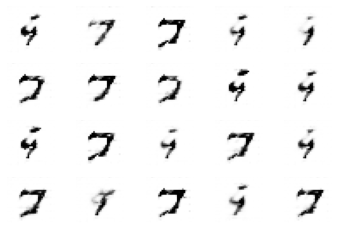


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 435200 samples:


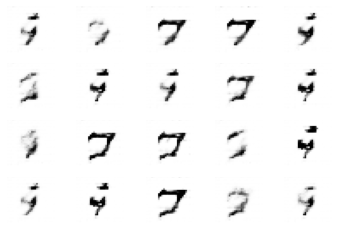


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 460800 samples:


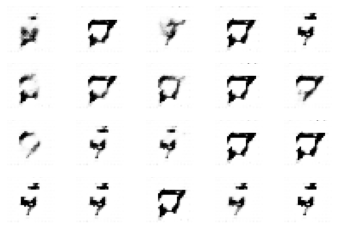


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 486400 samples:


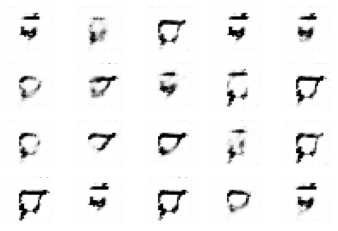


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 512000 samples:


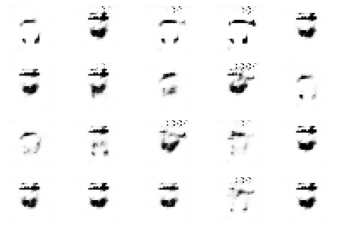


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 537600 samples:


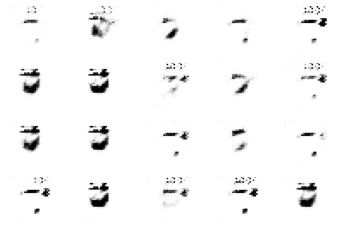


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 563200 samples:


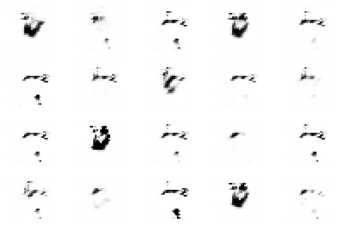


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 588800 samples:


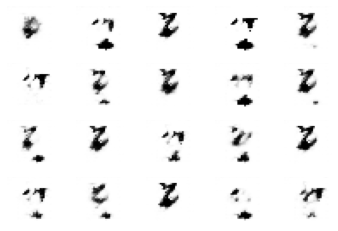


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 614400 samples:


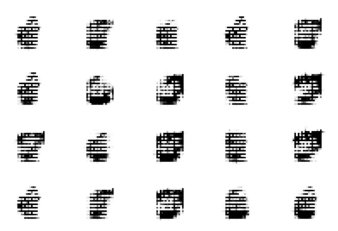


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 640000 samples:


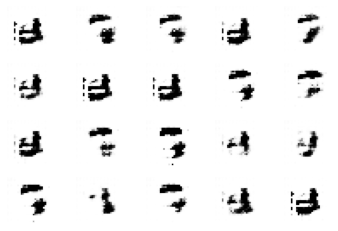


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 665600 samples:


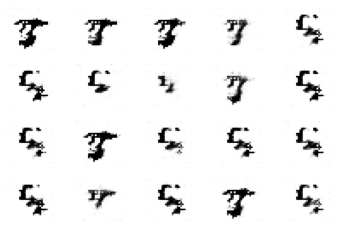


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 691200 samples:


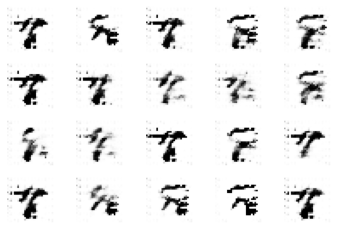


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 716800 samples:


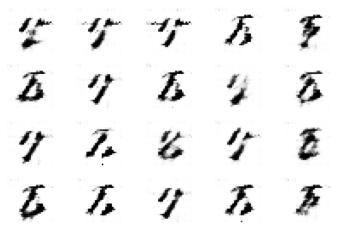


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 742400 samples:


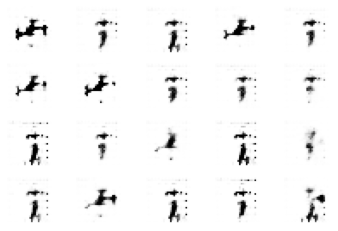


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 768000 samples:


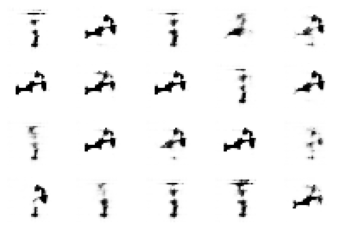


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 793600 samples:


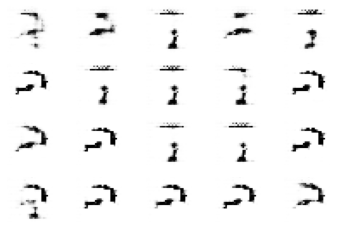


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 819200 samples:


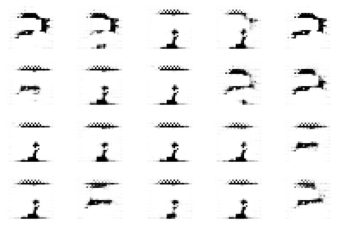


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 844800 samples:


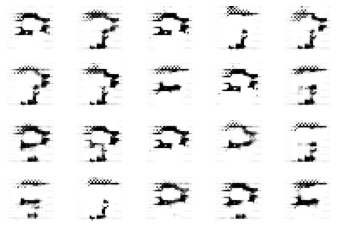


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 870400 samples:


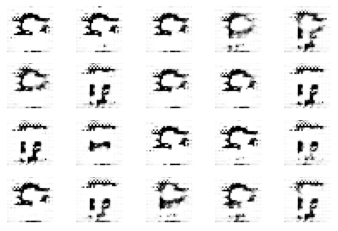


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 896000 samples:


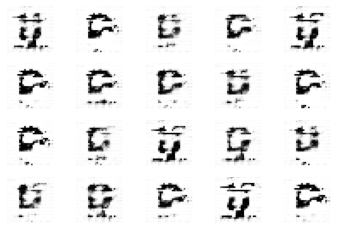


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 921600 samples:


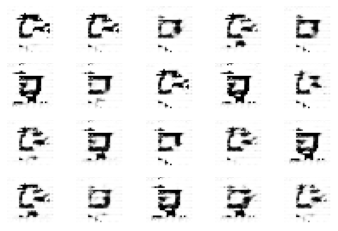


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 947200 samples:


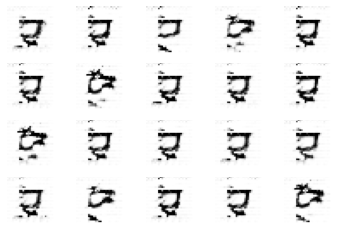


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 972800 samples:


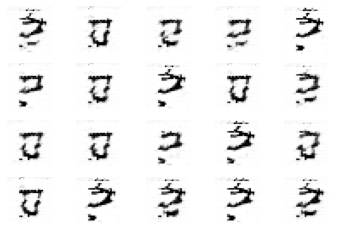


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 998400 samples:


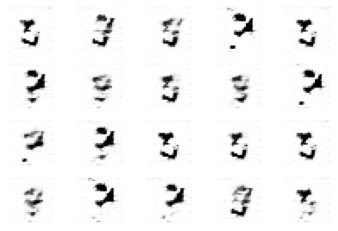


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1024000 samples:


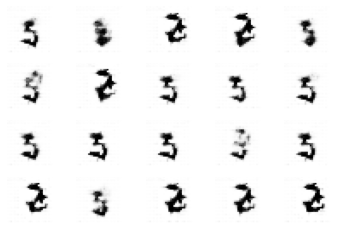


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1049600 samples:


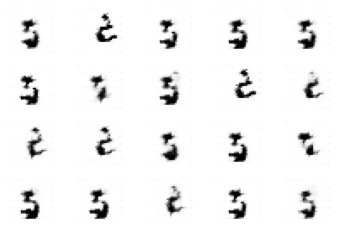


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1075200 samples:


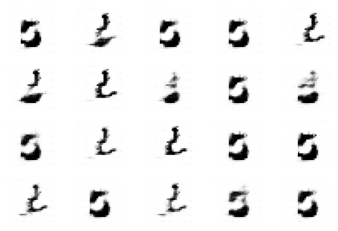


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1100800 samples:


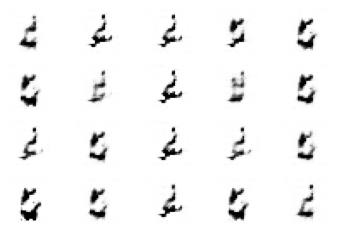


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1126400 samples:


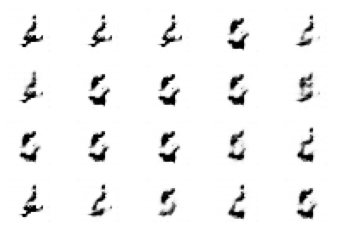


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1152000 samples:


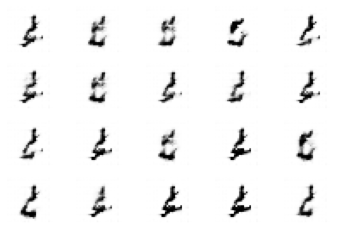


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1177600 samples:


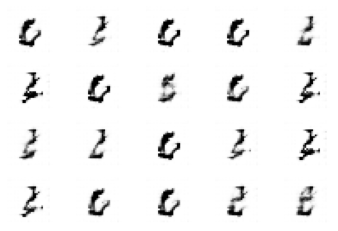


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1203200 samples:


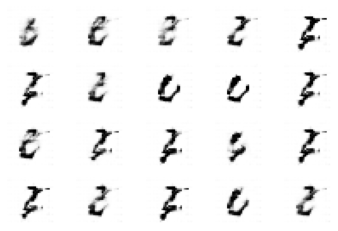


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1228800 samples:


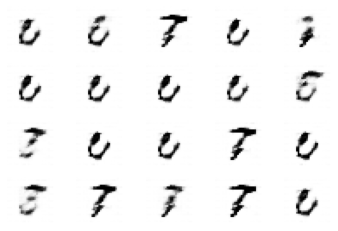


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1254400 samples:


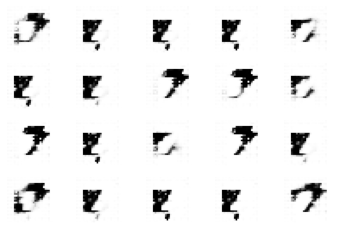


Training... 
Discriminator Real Acc, Discriminator Fake Acc, Generator Acc
After 1280000 samples:


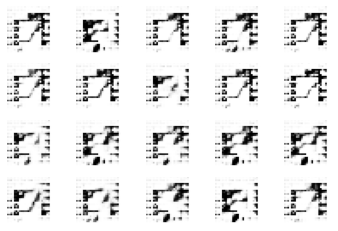

In [11]:
for i in range(EVALUATION_ROUNDS):
    train_gan(gan, generator, discriminator, NOISE_DIM, BATCHES, BATCH_SIZE, verbose=False)
    print(f'After {(i+1)*BATCHES*BATCH_SIZE} samples:')
    
    # To evaluate, we'll look at 20 randomly generated samples.
    fake_images, _ = generate_fake_batch(generator, NOISE_DIM, 20)

    for i in range(20):
        ax = plt.subplot(4, 5, i+1)
        ax.axis('off')
        plt.imshow(fake_images[i, :, :, 0], cmap='Greys')

    plt.show()
    print()

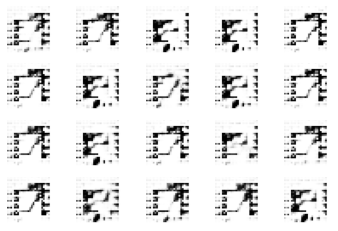

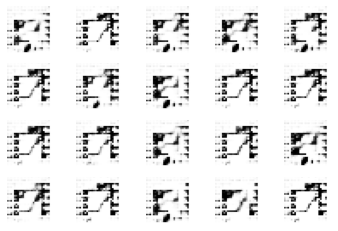

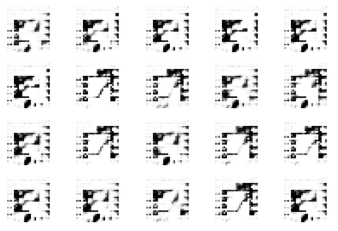

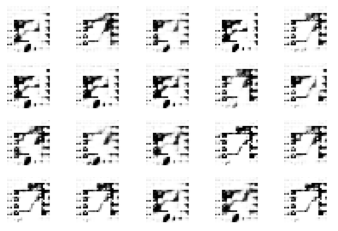

In [12]:
# And, after training on ~2.5M samples, lets look at a larger selection
# of generated digits.
for j in range(4):
    fake_images, _ = generate_fake_batch(generator, NOISE_DIM, 20)

    for i in range(20):
        ax = plt.subplot(4, 5, i+1)
        ax.axis('off')
        plt.imshow(fake_images[i, :, :, 0], cmap='Greys')
    
    plt.show()

In [13]:
generator.save('saved_models/mnist_gen_final.h5')
discriminator.save('saved_models/mnist_discriminator_final.h5')